Projet : Concevez une application au service de la santé publique

Notebook d'exploration des données
<br>
Created by: Thomas Durand-Texte, 2023

**Table of contents**<a id='toc0_'></a>    
- [Chargement des packages et des données](#toc1_)    
  - [Import des packages](#toc1_1_)    
  - [Paramètres graphiques et fonctions utiles](#toc1_2_)    
  - [Chargement des données](#toc1_3_)    
- [Remplissage des valeurs](#toc2_)    
  - [Valeurs éparses](#toc2_1_)    
    - [Valeur moyenne par pnns_groups](#toc2_1_1_)    
    - [Iterative imputer](#toc2_1_2_)    
  - [K-nn : nutriscore](#toc2_2_)    
  - [Vérification de la (non-)corrélation des variables](#toc2_3_)    
  - [Mise à jour des variables](#toc2_4_)    
  - [Scaling](#toc2_5_)    
  - [Avec fibres / sans fibres](#toc2_6_)    
  - [Ajout de la variable pnns_group (code)](#toc2_7_)    
  - [K-NN par pnns_group](#toc2_8_)    
  - [Estimation nutriscore](#toc2_9_)    
- [Analyse de l'inertie des varialbes - Analyse en Composantes Principales](#toc3_)    
  - [Extration des données](#toc3_1_)    
  - [Scaling, instanciation et entrainement ACP](#toc3_2_)    
  - [Éboulis des valeurs prorpres - Affichage de la variance captée](#toc3_3_)    
  - [Composantes](#toc3_4_)    
  - [Cercle des corrélations](#toc3_5_)    
  - [Projection - plans factoriels](#toc3_6_)    
- [Analyses liées à l'application proposée](#toc4_)    
  - [Statistiques sur la répartition des nutriscore_grade et pnns_groups](#toc4_1_)    
  - [ANOVA](#toc4_2_)    
  - [Scatter plots](#toc4_3_)    
  - [Observations des listes d'ingrédients](#toc4_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Chargement des packages et des données](#toc0_)
## <a id='toc1_1_'></a>[Import des packages](#toc0_)

In [59]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option("display.max_columns", 200)
import missingno as msno

import datetime as dt
import scipy.stats as st


import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn import neighbors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cm = 1./2.54


## <a id='toc1_2_'></a>[Paramètres graphiques et fonctions utiles](#toc0_)

In [60]:
import os
import subprocess

white_font = True

def set_theme():
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3, 
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':True,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'cm' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True }
 
    sns.set_theme( 'notebook' , rc=rc )

set_theme()
del set_theme



## <a id='toc1_3_'></a>[Chargement des données](#toc0_)

In [61]:
data = pd.read_pickle( 'data_clean.pkl' )
print(data.keys().tolist())

['code', 'product_name', 'ingredients_text', 'allergens', 'additives_n', 'additives_tags', 'additives_en', 'nutriscore_score', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'energy-kj_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']


Création d'une variable pour accéder facilement aux données par 100g.

In [62]:
keys_100g = pd.Series( data.keys()[ data.keys().str.contains('_100g') ] )
print( 'keys 100g:', keys_100g.tolist() )

keys 100g: ['energy-kj_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']


***
# <a id='toc2_'></a>[Remplissage des valeurs](#toc0_)

## <a id='toc2_1_'></a>[Valeurs éparses](#toc0_)

### <a id='toc2_1_1_'></a>[Valeur moyenne par pnns_groups](#toc0_)
Clairement, les distributions ne sont `pas Gaussiennes` dans chaque catégorie: plusieurs `modes` sont visibles. `Remplacer` les `NaN` avec la `valeur moyenne` dans chaque catégorie n'est donc pas idéale.
Le nombre de NaN est cependant relativement faible et le modifications ne sont pas clairement visible.

Number of added values:


energy-kj_100g         243
fat_100g               634
saturated-fat_100g    1250
carbohydrates_100g     488
sugars_100g            481
fiber_100g               0
proteins_100g          182
salt_100g             3077
sodium_100g           3074
dtype: int64

Vérification composite foods - energy-kj_100g:
mean (initial data) energy-kj_100g: 765.570
initial data:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
data_mean:
[765.5696237 765.5696237 765.5696237 765.5696237 765.5696237 765.5696237
 765.5696237 765.5696237 765.5696237 765.5696237 765.5696237 765.5696237
 765.5696237 765.5696237 765.5696237 765.5696237 765.5696237 765.5696237
 765.5696237 765.5696237 765.5696237 765.5696237 765.5696237 765.5696237
 765.5696237]

initial:
data energy-kj_100g (composite foods) mean: 765.570, modified: 765.570

re-computed loc:
data energy-kj_100g (composite foods) mean: 765.570, modified: 765.570


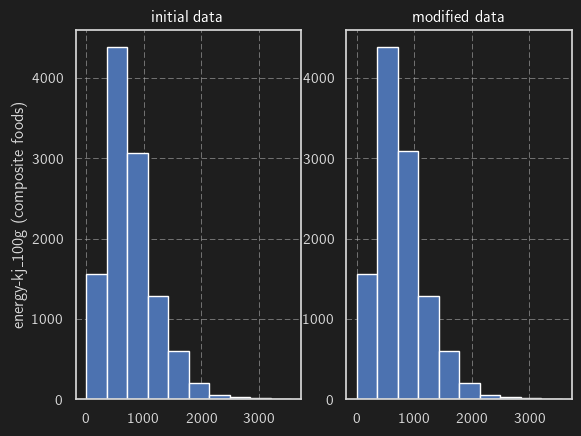

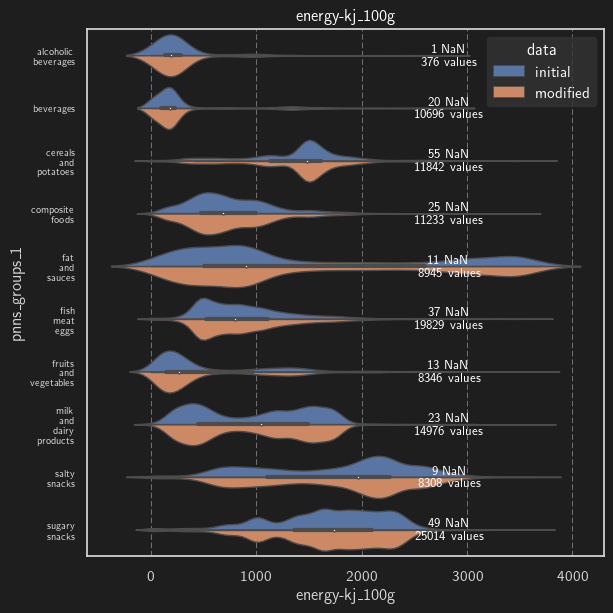

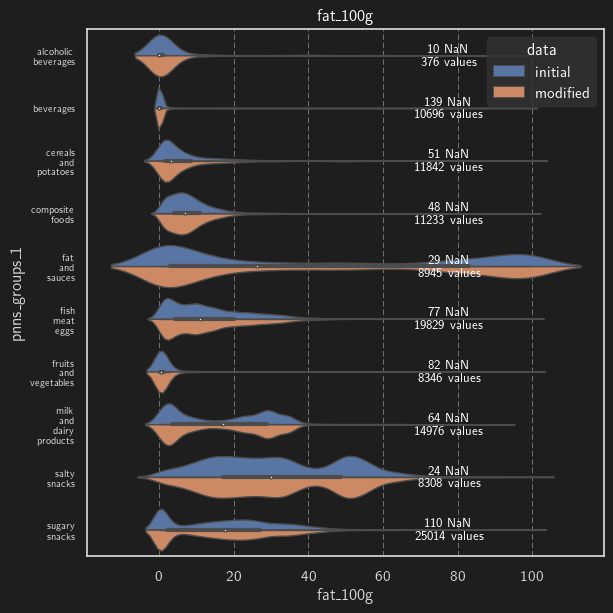

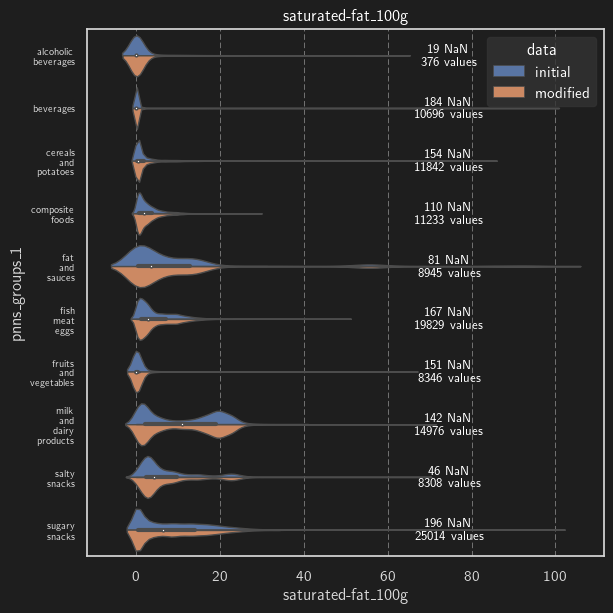

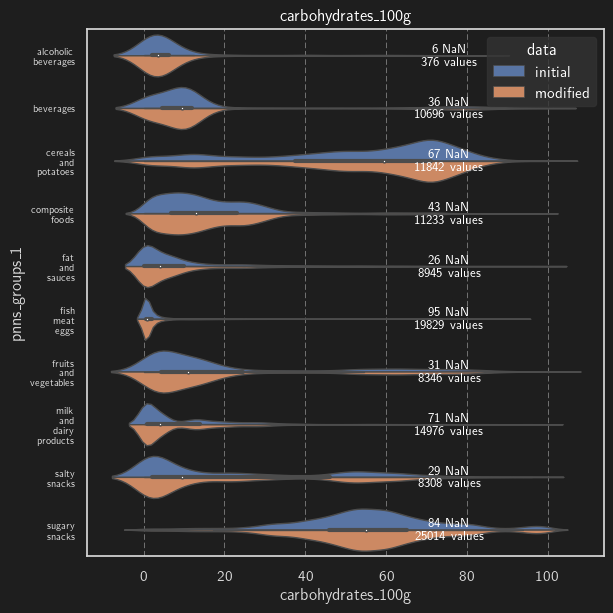

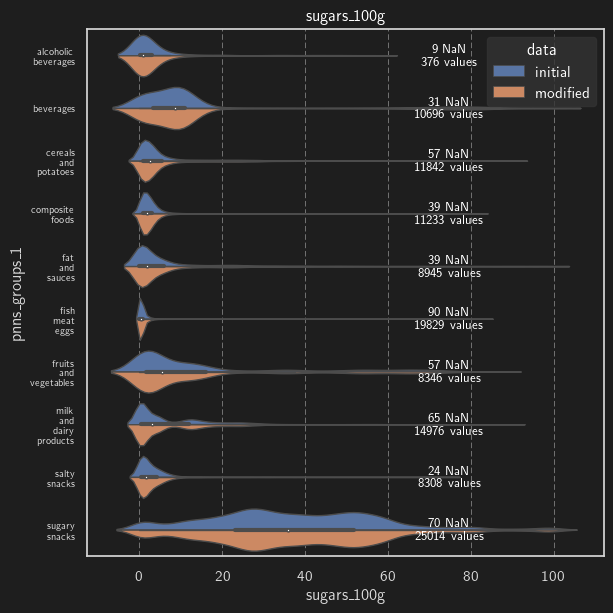

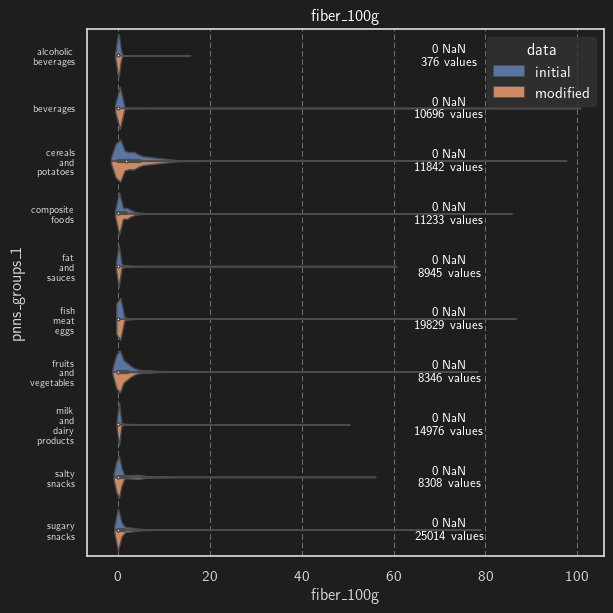

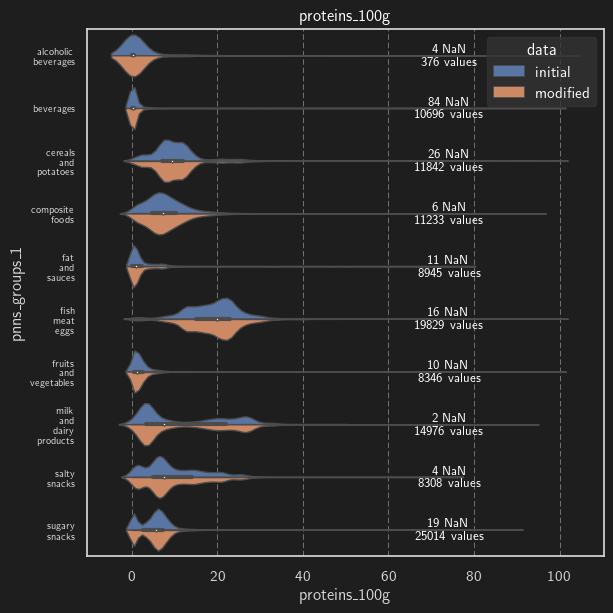

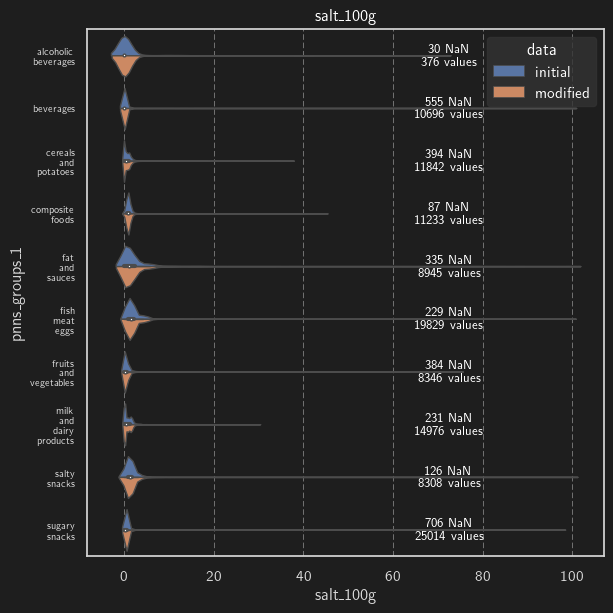

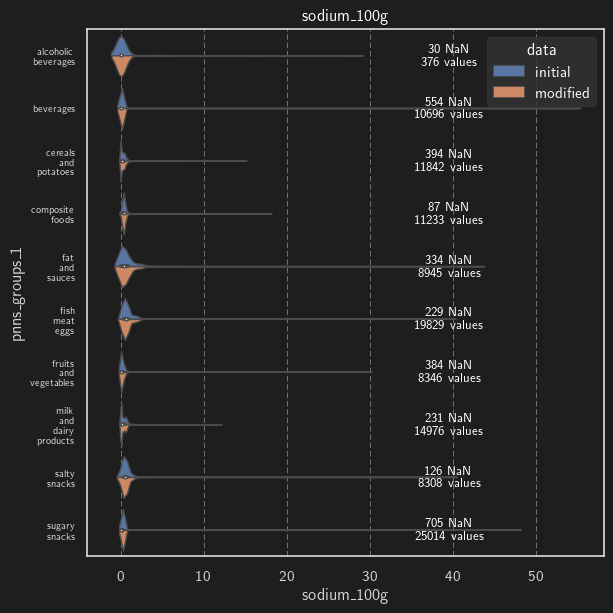

In [63]:
data['data'] = pd.Series('initial', index=data.index, dtype='category')

# new data set with fillna with median value in each pnns_groups_1
data_mean = data.copy()
data_mean['data'] = data_mean['data'].map( {'initial':'modified'} )
groups = data[ keys_100g.tolist() + ['pnns_groups_1'] ].groupby( 'pnns_groups_1' )

# .transform(lambda x: x.fillna(x.mean()))

# apply only if pnns_groups is defined
data_mean.loc[ ~(data_mean['pnns_groups_1'].isna()) , keys_100g ] = data_mean[keys_100g].fillna( groups.transform('mean') )


print('Number of added values:')
display( data[keys_100g].isna().sum(0) - data_mean[keys_100g].isna().sum(0) )

# check process : differents values were tested to check the process
key = 'energy-kj_100g'
pnns = 'alcoholic beverages'
pnns = 'composite foods'
sr_loc = data[key].isna() & (data['pnns_groups_1'] == pnns)
sr_loc0 = ~data[key].isna() & (data['pnns_groups_1'] == pnns)

print('Vérification {:} - {:}:'.format(pnns, key))

print('mean (initial data) {:}: {:.3f}'.format(key, data.loc[ data['pnns_groups_1']==pnns, key].mean()  ))
print( 'initial data:')
print( data.loc[sr_loc, key].values )
print( 'data_mean:')
print( data_mean.loc[sr_loc, key].values )

sr_loc2 = (data['pnns_groups_1'] == pnns)
print('\ninitial:')
print('data {:} ({:}) mean: {:.3f}, modified: {:.3f}'.format( key, pnns, data.loc[sr_loc0,key].mean(), data_mean.loc[sr_loc,key].mean() ) )
print('\nre-computed loc:\ndata {:} ({:}) mean: {:.3f}, modified: {:.3f}'.format( key, pnns, data.loc[sr_loc2,key].mean(), data_mean.loc[sr_loc2,key].mean() ) )

fig, axs = plt.subplots( ncols=2 )
axs[0].hist( data.loc[sr_loc2, key] )
axs[1].hist( data_mean.loc[sr_loc2, key] )
axs[0].set_ylabel( '{:} ({:})'.format(key, pnns) )
axs[0].set_title('initial data')
axs[1].set_title('modified data')

for key in keys_100g:
    
    fig, ax = plt.subplots( figsize=(16*cm,16*cm) )
    ax.set_title( key )
    sns.violinplot( y='pnns_groups_1', x=key, data=pd.concat( (data, data_mean) ), ax=ax,
        linewidth=1, scale='count', hue='data', split=True )
    
    xlim = ax.get_xlim()
    xi = xlim[0] + 0.7 * (xlim[1]-xlim[0])
    for i, (name, group) in enumerate(groups):
        isna = group[key].isna()
        ax.annotate( '{:} NaN\n{:} values'.format( isna.sum(), len(isna)), [xi, i], va='center', ha='center', fontsize=9 )

    ax.set_yticklabels( [label.get_text().replace(' ', '\n') for label in ax.get_yticklabels()] , fontsize=7 )

    fig.tight_layout( )


### <a id='toc2_1_2_'></a>[Iterative imputer](#toc0_)
Les résultats sont `visuellement corrects` (peu de modification des distributions) excepté des `valeurs aberrantes ajoutée`.

Number of added values:


energy-kj_100g          348
fat_100g               1188
saturated-fat_100g     2070
carbohydrates_100g     1008
sugars_100g             706
fiber_100g                0
proteins_100g           251
salt_100g             12322
sodium_100g           12313
dtype: int64


statistics on initial data:


energy-kj_100g       fat_100g  saturated-fat_100g  carbohydrates_100g  \
count   243685.000000  242845.000000       241963.000000       243025.000000   
mean      1143.544815      14.374656            5.512605           27.327613   
std        751.269090      17.484592            7.973786           27.656966   
min          0.000000       0.000000            0.000000            0.000000   
25%        490.000000       1.200000            0.290000            2.900000   
50%       1099.800000       8.300000            2.100000           14.000000   
75%       1665.000000      22.600000            8.100000           52.000000   
max       3700.000000     100.000000          100.000000          100.000000   

         sugars_100g     fiber_100g  proteins_100g      salt_100g  \
count  243327.000000  244033.000000  243782.000000  231711.000000   
mean       13.799753       0.768969       8.993311       1.287231   
std        19.998042       2.988072       9.975714       4.302063   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.700000       0.000000       1.700000       0.090000   
50%         3.510000       0.000000       6.300000       0.590000   
75%        20.000000       0.000000      13.000000       1.370000   
max       100.000000     100.000000     100.000000     100.000000   

         sodium_100g  
count  231720.000000  
mean        0.516966  
std         1.753479  
min         0.000000  
25%         0.036000  
50%         0.236000  
75%         0.548000  
max        68.000000


statistics on modified:


energy-kj_100g       fat_100g  saturated-fat_100g  carbohydrates_100g  \
count   244033.000000  244033.000000       244033.000000       244033.000000   
mean      1143.549084      14.359190            5.503366           27.321190   
std        751.172427      17.464656            7.954059           27.623784   
min          0.000000     -36.951433           -9.314530          -84.123275   
25%        491.000000       1.200000            0.300000            2.900000   
50%       1099.000000       8.300000            2.100000           14.200000   
75%       1665.000000      22.540000            8.100000           52.000000   
max       5376.120845     100.000000          100.000000          109.442587   

         sugars_100g     fiber_100g  proteins_100g      salt_100g  \
count  244033.000000  244033.000000  244033.000000  244033.000000   
mean       13.791077       0.768969       8.991247       1.292104   
std        19.983490       2.988072       9.972094       4.271679   
min       -45.741517       0.000000     -13.750140       0.000000   
25%         0.700000       0.000000       1.700000       0.100000   
50%         3.600000       0.000000       6.300000       0.660000   
75%        20.000000       0.000000      13.000000       1.300000   
max       100.000000     100.000000     100.000000     170.000212   

         sodium_100g  
count  244033.000000  
mean        0.516838  
std         1.708669  
min         0.000000  
25%         0.040000  
50%         0.264000  
75%         0.520000  
max        68.000000

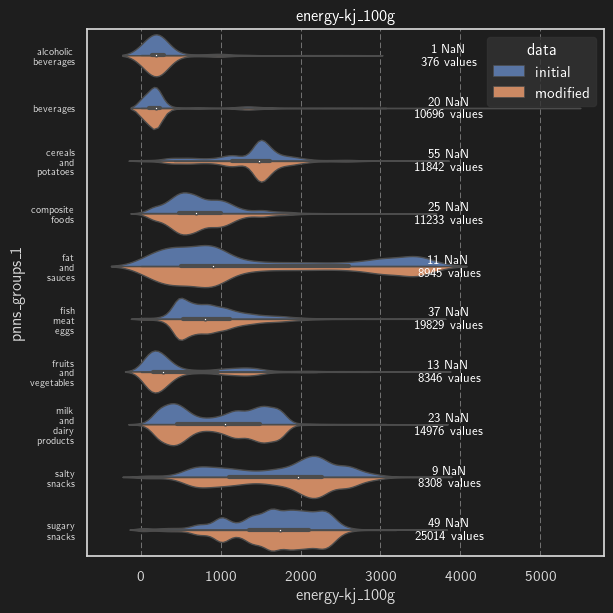

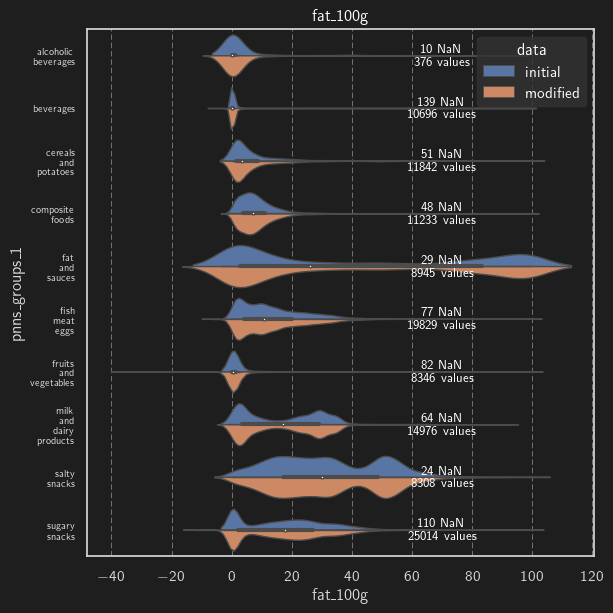

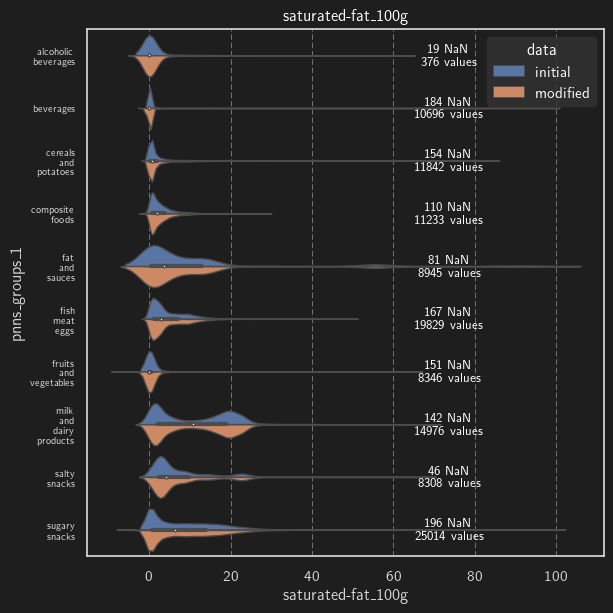

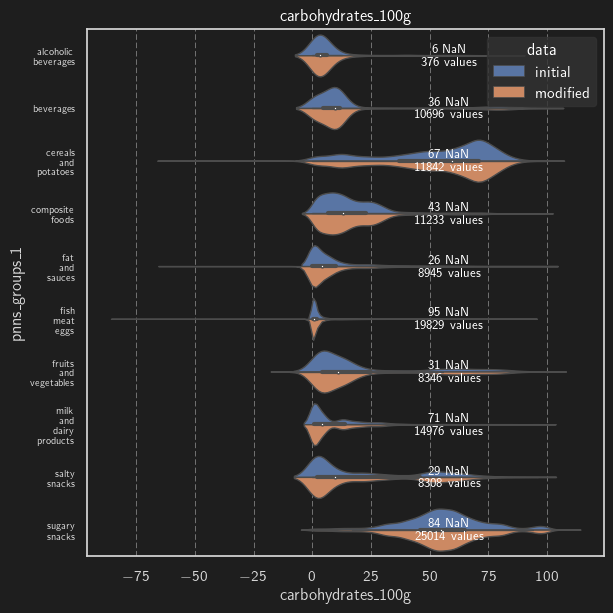

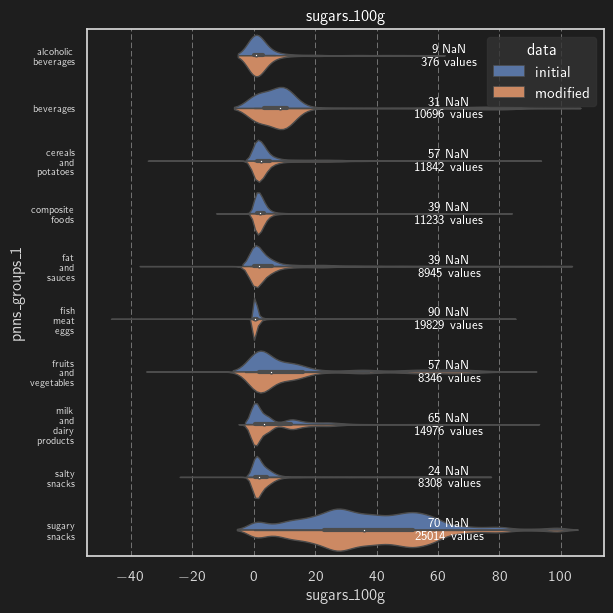

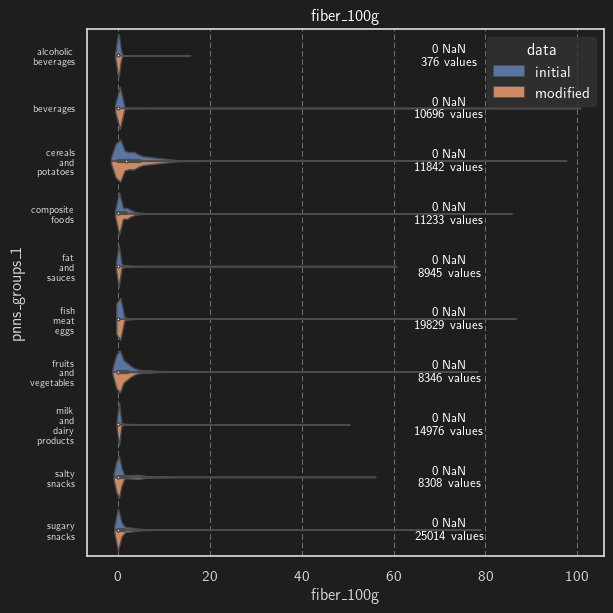

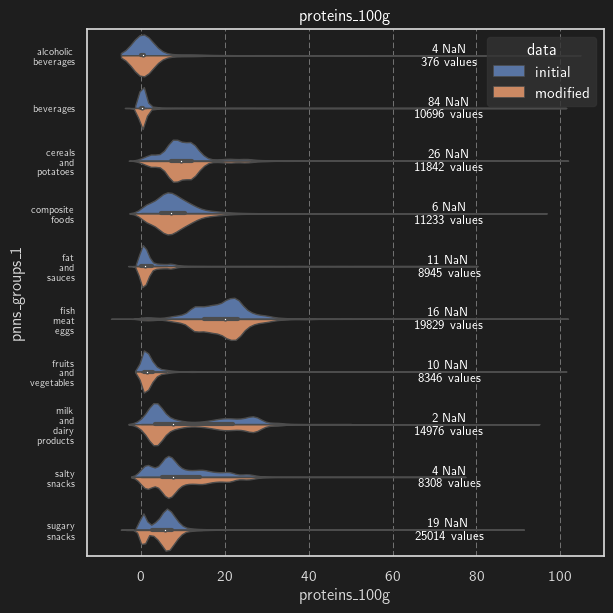

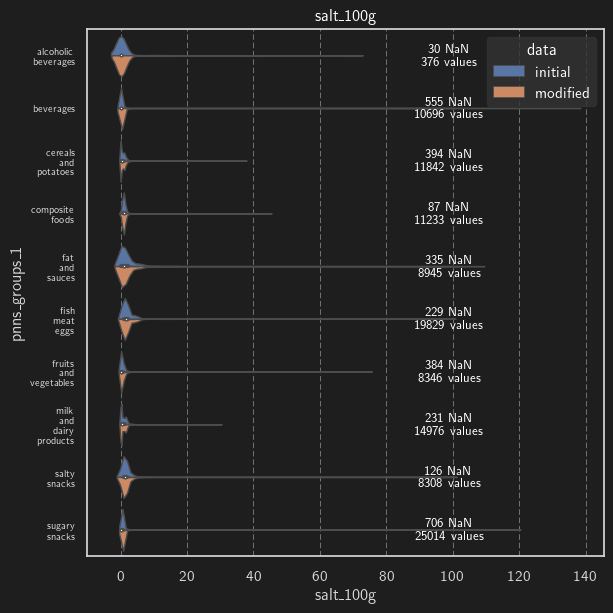

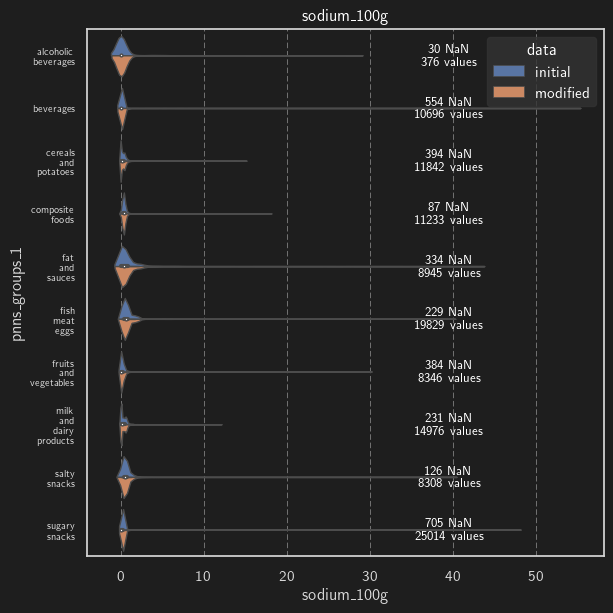

In [64]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


v_isall_filled = data[keys_100g].isna().sum(1) == 0


imp = IterativeImputer(max_iter=10, random_state=0)

imp.fit( data.loc[ v_isall_filled, keys_100g].values )
IterativeImputer(random_state=0)

data_imputer = data.copy()
data_imputer['data'] = data_imputer['data'].map({'initial':'modified'}) # pour affichage dans graphiques

data_imputer.loc[ ~v_isall_filled, keys_100g ] = \
                imp.transform( data.loc[~v_isall_filled, keys_100g ].values )

print('Number of added values:')
display( data[keys_100g].isna().sum(0) - data_imputer[keys_100g].isna().sum(0) )


print('\nstatistics on initial data:')
display( data[keys_100g].describe() )
print('\nstatistics on modified:')
display( data_imputer[keys_100g].describe() )

for key in keys_100g:
    fig, ax = plt.subplots( figsize=(16*cm,16*cm) )
    ax.set_title( key )
    sns.violinplot( y='pnns_groups_1', x=key, data=pd.concat((data, data_imputer)), ax=ax,
        linewidth=1, scale='count', hue='data', split=True )
    ax.set_yticklabels( [label.get_text().replace(' ', '\n') for label in ax.get_yticklabels()] , fontsize=7 )

    xlim = ax.get_xlim()
    xi = xlim[0] + 0.7 * (xlim[1]-xlim[0])
    for i, (name, group) in enumerate(groups):
        isna = group[key].isna()
        ax.annotate( '{:} NaN\n{:} values'.format( isna.sum(), len(isna)), [xi, i], va='center', ha='center', fontsize=9 )

    fig.tight_layout()

## <a id='toc2_2_'></a>[K-nn : nutriscore](#toc0_)

In [65]:
data_new = data # initial dataset

Définition d'une fonction k-nn

In [66]:
def fit_and_test_knn( xtrain,ytrain, xtest,ytest, kmin, kmax ):
    errors, dico_knn = [], {}
    for k in range(kmin, min(kmax+1, len(ytrain) ) ):
        print('k: {:02}'.format(k), end='\r')
        if ytrain.dtype in ['object', 'category']:
            knn = neighbors.KNeighborsClassifier(k)
        else:
            knn = neighbors.KNeighborsRegressor(k)
        dico_knn[k] = knn
        # knn.fit(xtrain, ytrain)
        errors.append(100*(1-knn.fit(xtrain, ytrain).score(xtest, ytest) ) )
    return dico_knn, np.array(errors)

Définition d'une fonction plot

In [67]:
def plot_knn( kmin, errors, ntrain, ntest, xtest_scaled,
            ytest, knn, key_target, key=None,
            label=None, axs=None, color='b' ):
    imin_error_knn = np.argmin(errors)
    k_min_error = kmin + imin_error_knn

    if axs is None:
        fig, axs = plt.subplots( ncols=2, figsize=(20*cm, 8*cm))
    else:
        fig = axs[0].get_figure()

    ax = axs[0]
    if not ytest is None and len(ytest) > 0:
        if key is None:
            fig.suptitle( 'n train: {:}, n test: {:}'.format( ntrain, len(ytest) ) )
        else:
            fig.suptitle( '{:} - n train: {:}, n test {:}'.format(key, ntrain, len(ytest) ) )

    ax.plot( range(kmin, kmin+len(errors)), errors, 'o-', color=color, label=label )
    ax.plot( [k_min_error], [errors[imin_error_knn]], 'or' )
    ax.set_xlabel( 'k neighbors')
    ax.set_ylabel(r'100*(1-R$^2$)')
    ax.annotate( '{:.2f}%'.format(errors[imin_error_knn]), 
            [k_min_error, errors[imin_error_knn] + 0.1*np.ptp(errors) ],
            color='r', va='bottom', ha='center')

    if label is None:
        label = 'prediction'
    else:
        label = None

    ax = axs[1]
    if not ytest is None and len(ytest) > 0: 
        ax.plot( ytest, 'r', label='y test' )
    ax.plot( knn.predict( xtest_scaled ), 'o', color=color,
                markersize=1, zorder=0, label=label )
    lgnd = ax.legend( )
    for handle in lgnd.legendHandles:
        handle.set_markersize(6.0) # change markersize in legend

    ax.set_xlabel( 'index test' )
    ax.set_ylabel( key_target )

    fig.tight_layout()
    return fig, axs

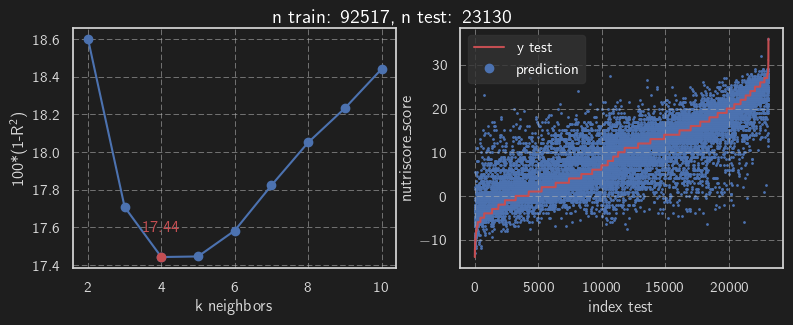

In [68]:
key_target = 'nutriscore_score'
sr_loc = data_new[keys_100g.tolist() + [key_target]].isna().sum(1) == 0


xtrain, xtest, ytrain, ytest = train_test_split( data_new.loc[sr_loc, keys_100g].values , 
                                    data_new.loc[sr_loc, key_target].values, train_size=0.8)

argsort = ytest.argsort()
xtest, ytest = xtest[argsort], ytest[argsort]

kmin, kmax = 2, 10

dico_knn, errors = fit_and_test_knn( xtrain,ytrain, xtest,ytest, kmin, kmax )

imin_error_knn = errors.argmin()
k_min_error = kmin + imin_error_knn
knn = dico_knn[imin_error_knn]

fig, ax = plot_knn( kmin, errors, len(ytrain), len(ytest), xtest, ytest, knn, key_target, key=None )
fig.tight_layout( )

Les résultats semblent assez peu fiables. Des améliorations sont clairement à apporter.

## <a id='toc2_3_'></a>[Vérification de la (non-)corrélation des variables](#toc0_)
- `carbohydrates` et `sugars`, `fat` et `saturated-fat` sont assez évidemment corrélés
- `salt` et `sodium` sont quasi parfaitement corrélés 

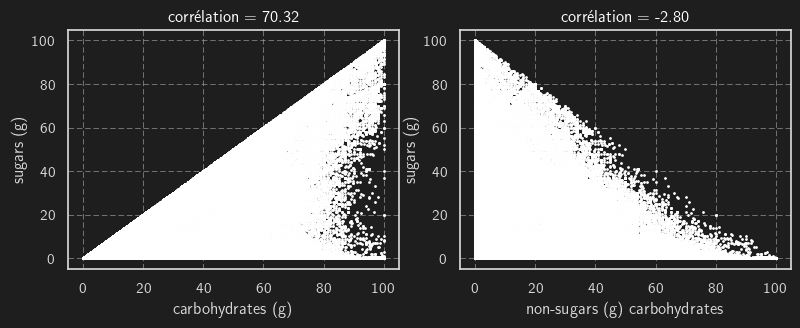

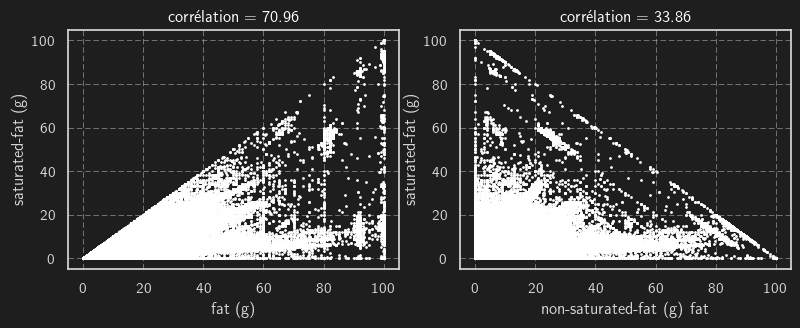

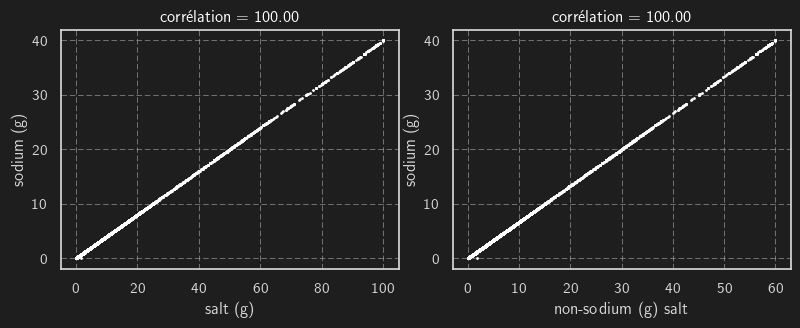

In [69]:
for key1,key2 in [('carbohydrates_100g','sugars_100g') , ('fat_100g', 'saturated-fat_100g'), ('salt_100g','sodium_100g') ]:
    df = data_new.loc[ data_new[[key1,key2]].isna().sum(1) == 0 , [key1,key2] ]
    fig, axs = plt.subplots( ncols=2, figsize=(20*cm,8*cm) )

    x, y = data_new[key1], data_new[key2]
    sr_loc = ~(x.isna() | y.isna())
    x, y = x.loc[sr_loc], y.loc[sr_loc]

    axs[0].plot( x, y, 'wo', markersize=1 )
    r = st.pearsonr( x, y)[0]
    axs[0].set_title('corrélation = {:.2f}%'.format( 100*r ) )
    axs[0].set_xlabel( '{:}'.format( key1.replace('_100g', ' (g)') ) )
    axs[0].set_ylabel( '{:}'.format( key2.replace('_100g', ' (g)') ) )

    # df.plot( kind='scatter', x=key1, y=key2, s=1, c='w' , ax=axs[0] )

    axs[1].plot( x-y, y, 'wo', markersize=1 )
    r = st.pearsonr( x-y, y)[0]
    axs[1].set_title('corrélation = {:.2f}%'.format( 100*r ) )
    
    axs[1].set_xlabel( 'non-{:} {:}'.format( key2.replace('_100g', ' (g)'), key1.replace('_100g', '') ) )
    axs[1].set_ylabel( '{:}'.format( key2.replace('_100g', ' (g)') ) )

    fig.tight_layout( )

## <a id='toc2_4_'></a>[Mise à jour des variables](#toc0_)
Fonction pour extraire un nouveau dataset:
- sans sodium
- fat $\rightarrow$ non-saturated-fat
- carbohydrates $\rightarrow$ non-sugar-carbohydrates

In [70]:
def updated_data( data ):
    data_new = data[ ['energy-kj_100g', 'saturated-fat_100g', 'sugars_100g',
                    'proteins_100g', 'salt_100g'] ].copy()
    data_new['non-saturated-fat_100g'] = data['fat_100g'] - data['saturated-fat_100g']
    data_new['non-sugar-carbohydrates_100g'] = data['carbohydrates_100g'] \
                                                - data['sugars_100g']
    data_new['fiber_100g'] = data['fiber_100g'].copy() # at the end for verification below
    return data_new

Test avec les nouvelles variables : pas d'amélioration flagrante pour le moment

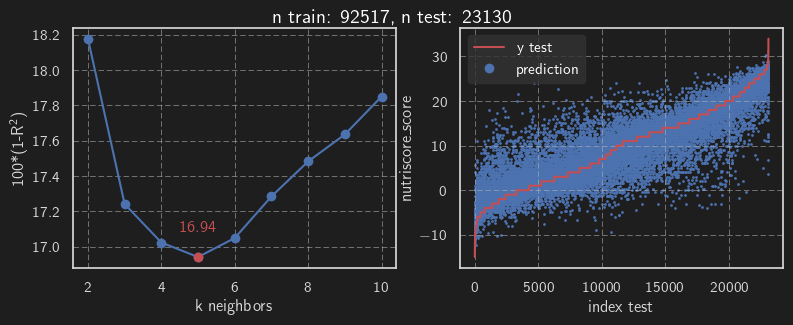

In [71]:
sr_loc = data_new[keys_100g.tolist() + [key_target]].isna().sum(1) == 0
xtrain, xtest, ytrain, ytest = train_test_split( updated_data(data_new.loc[sr_loc, keys_100g]).values , 
                                    data_new.loc[sr_loc, key_target].values, train_size=0.8 )

argsort = ytest.argsort()
xtest, ytest = xtest[argsort], ytest[argsort]

dico_knn, errors = fit_and_test_knn( xtrain,ytrain, xtest,ytest, kmin, kmax )

imin_error_knn = errors.argmin()
k_min_error = kmin + imin_error_knn
knn = dico_knn[imin_error_knn]

fig, ax = plot_knn( kmin, errors, len(ytrain), len(ytest), xtest, ytest, knn, key_target, key=None )
fig.tight_layout( )

## <a id='toc2_5_'></a>[Scaling](#toc0_)
Centrer et normer les données améliore les résultats, mais les écarts restent conséquents.

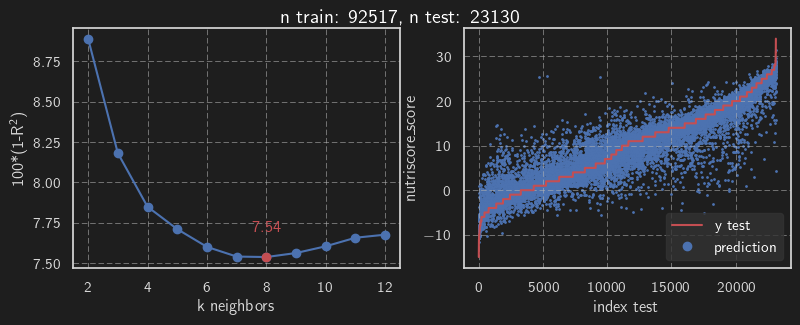

In [72]:
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_scaled = scaler.transform(xtrain)
xtest_scaled = scaler.transform(xtest)


kmin, kmax = 2, 12


dico_knn, errors = fit_and_test_knn( xtrain_scaled,ytrain, xtest_scaled,ytest, kmin, kmax )

imin_error_knn = errors.argmin()
k_min_error = kmin + imin_error_knn
knn = dico_knn[imin_error_knn]

fig, ax = plot_knn( kmin, errors, len(ytrain), len(ytest), xtest_scaled, ytest, knn, key_target, key=None )
fig.tight_layout( )

## <a id='toc2_6_'></a>[Avec fibres / sans fibres](#toc0_)

In [73]:
data_w_fibres = updated_data(data_new.loc[sr_loc, keys_100g])

y_fibres = data_new.loc[sr_loc, key_target].values

xtrain, xtest, ytrain, ytest = train_test_split( data_w_fibres.values , 
                                    y_fibres, train_size=0.8 )

# sans fibres
isna_train = np.isnan( xtrain[:,-1] )
isna_test = np.isnan( xtest[:,-1] )
xtrain[isna_train,-1] = 0. # supposition that NaN values corresponds to 0 values
xtest[isna_test,-1] = 0.

argsort = ytest.argsort()
xtest, ytest = xtest[argsort], ytest[argsort]


scaler = StandardScaler()
scaler.fit(xtrain[:,:-1])
xtrain_scaled = scaler.transform(xtrain[:,:-1])
xtest_scaled_0 = scaler.transform(xtest[:,:-1])


kmin, kmax = 2, 12


dico_knn_0, errors_0 = fit_and_test_knn( xtrain_scaled,ytrain, xtest_scaled_0,ytest, kmin, kmax )

imin_error_knn_0 = errors_0.argmin()
k_min_error_0 = kmin + imin_error_knn_0
knn_0 = dico_knn_0[imin_error_knn_0]


# avec fibres
scaler_1 = StandardScaler()
scaler_1.fit(xtrain)
xtrain_scaled = scaler_1.transform(xtrain)
xtest_scaled_1 = scaler_1.transform(xtest)




dico_knn_1, errors_1 = fit_and_test_knn( xtrain_scaled,ytrain, xtest_scaled_1,ytest, kmin, kmax )

imin_error_knn_1 = errors_1.argmin()
k_min_error_1 = kmin + imin_error_knn_1
knn_1 = dico_knn_1[imin_error_knn_1]

Affichage des résultats

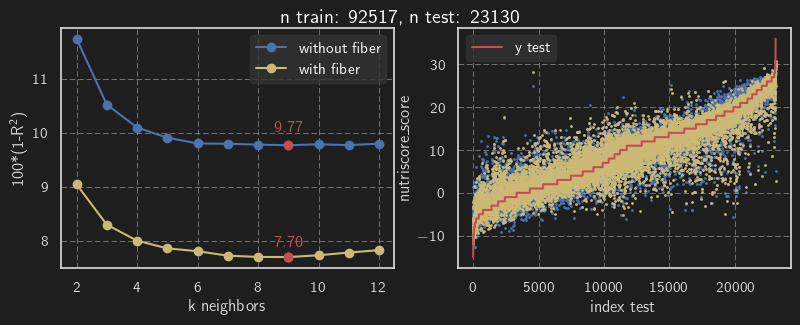

In [74]:
fig, axs = plt.subplots( ncols=2, figsize=(20*cm, 8*cm))
_ = plot_knn( kmin, errors_0, len(ytrain), len(ytest), xtest_scaled_0,
        ytest, knn_0, key_target, key=None,
        label='without fiber', axs=axs, color='b' )

_ = plot_knn( kmin, errors_1, len(ytrain), len(ytest), xtest_scaled_1,
        None, knn_1, key_target, key=None,
        label='with fiber', axs=axs, color='y' )

axs[0].legend()
fig.tight_layout( )

## <a id='toc2_7_'></a>[Ajout de la variable pnns_group (code)](#toc0_)
- Amélioration non négligeable des résultats
- Les codes ne sont pas ordonnés de manière hiérarchique, ce qui améliorerai possiblement les résultats
- le procees est uniquement valable pour valeurs avec pnns groups

(<Figure size 787.402x314.961 with 2 Axes>,
 array([<AxesSubplot: xlabel='k neighbors', ylabel='100*(1-R$^2$)'>,
        <AxesSubplot: xlabel='index test', ylabel='nutriscore_score'>],
       dtype=object))

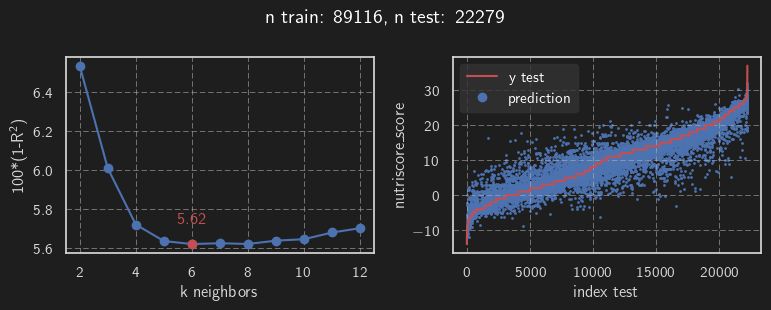

In [87]:
sr_loc = data_new[keys_100g.tolist() + ['pnns_groups_1']
                 + [key_target]].isna().sum(1) == 0
data_tmp = updated_data(data_new.loc[sr_loc, keys_100g.tolist() ])
data_tmp['pnns_groups_1'] = data_new.loc[sr_loc,'pnns_groups_1'].cat.codes

xtrain, xtest, ytrain, ytest = train_test_split( data_tmp.values , 
                                data_new.loc[sr_loc, key_target].values, train_size=0.8)

argsort = ytest.argsort()
xtest, ytest = xtest[argsort], ytest[argsort]

isna_train = np.isnan( xtrain[:,-1] )
isna_test = np.isnan( xtest[:,-1] )
xtrain[isna_train,-1] = 0. # supposition that NaN values corresponds to 0 values
xtest[isna_test,-1] = 0.



scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_scaled = scaler.transform(xtrain)
xtest_scaled = scaler.transform(xtest)


kmin, kmax = 2, 12

dico_knn, errors = fit_and_test_knn( xtrain_scaled,ytrain, xtest_scaled,ytest, kmin, kmax )

imin_error_knn = errors.argmin()
k_min_error = kmin + imin_error_knn
knn = dico_knn[imin_error_knn]

plot_knn( kmin, errors, len(ytrain), len(ytest), xtest_scaled, ytest, knn, key_target, key=None )


## <a id='toc2_8_'></a>[K-NN par pnns_group](#toc0_)
Résultats intéressants pour certaines catégories, mais pour certaines il n'y a pas assez de données.

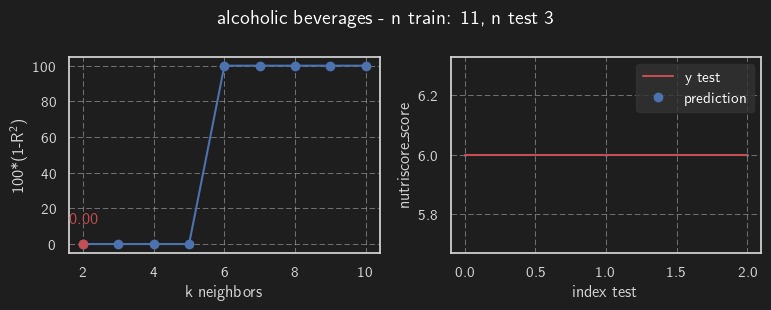

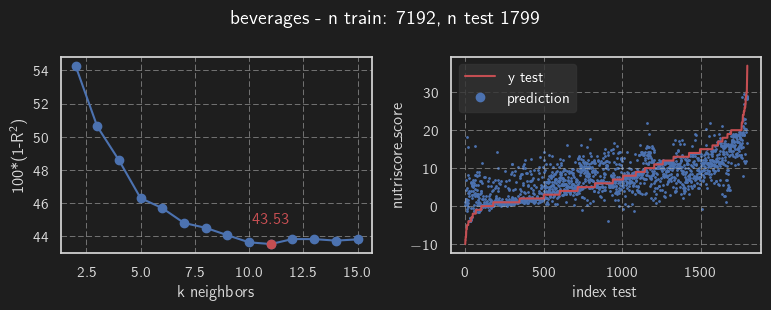

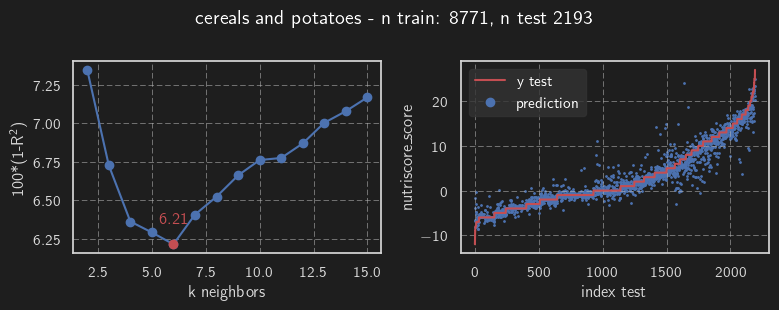

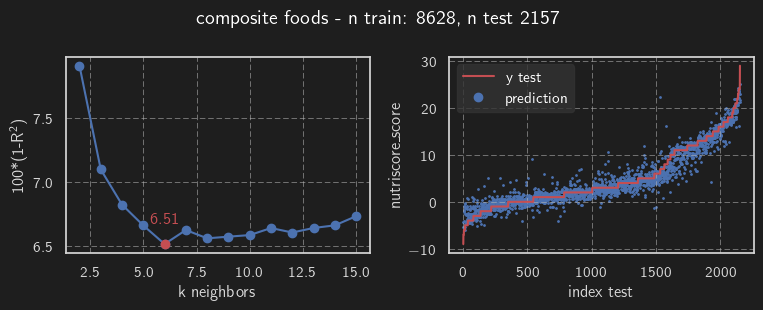

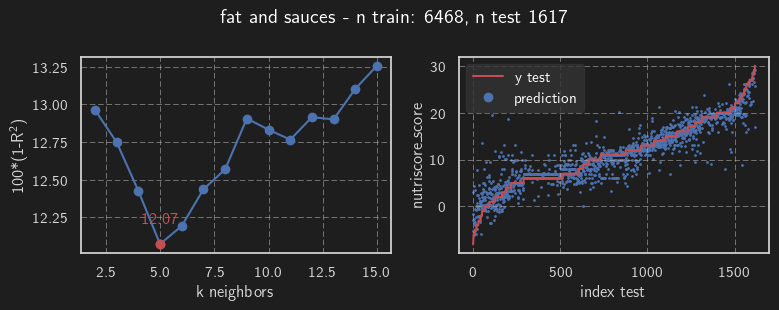

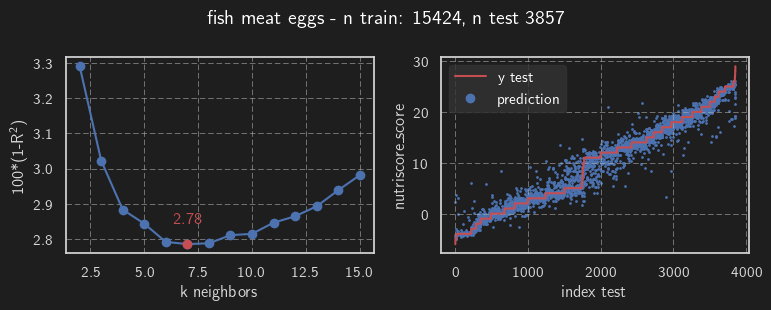

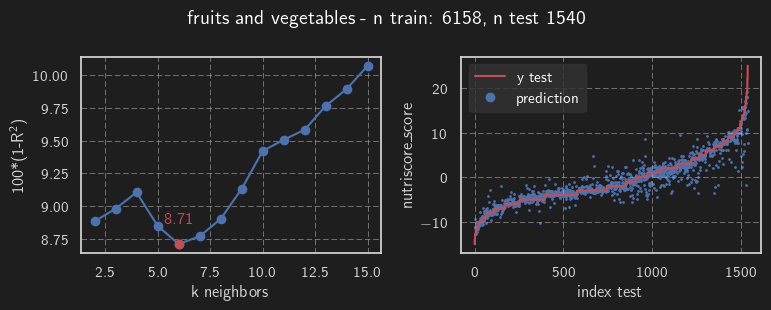

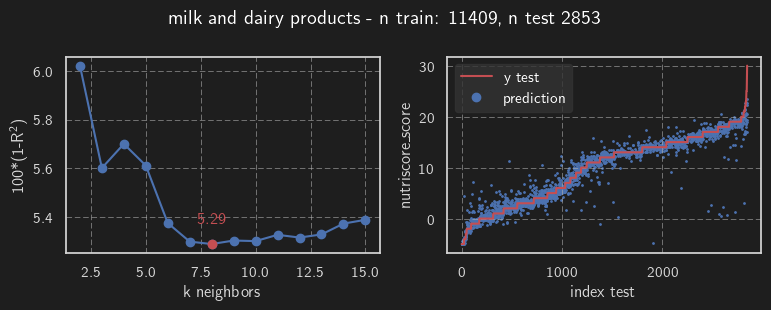

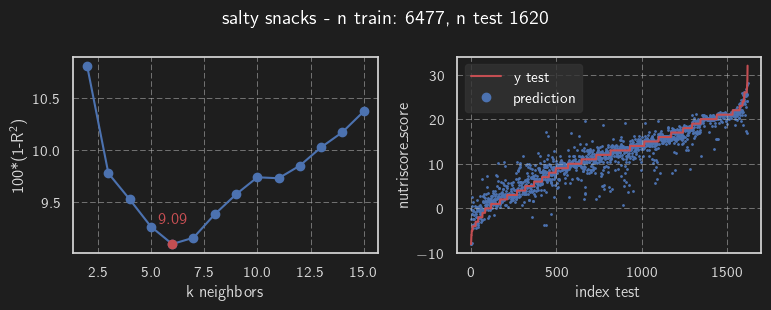

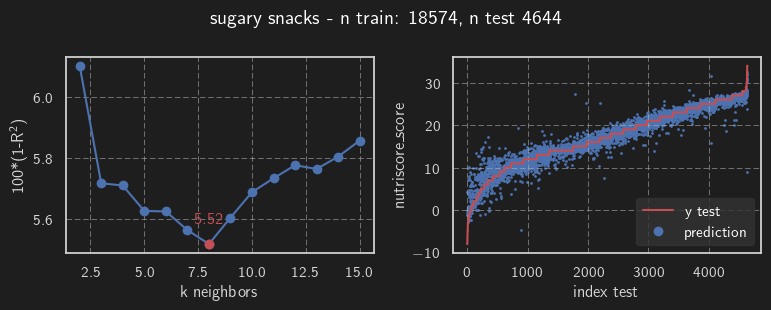

In [88]:
kmin, kmax = 2, 15


dico_knns = {}
for key in data_new['pnns_groups_1'].cat.categories:
    sr_loc2 = (data_new['pnns_groups_1'] == key) & sr_loc
    # print('sr_loc', sr_loc.sum(), 'sr_loc2', sr_loc2.sum() , (data_new['pnns_groups_1'] == key).sum() )
    if sr_loc2.sum() < 10: continue
    xtrain, xtest, ytrain, ytest = train_test_split( data_new.loc[sr_loc2, keys_100g].values , 
                                    data_new.loc[sr_loc2, key_target].values, train_size=0.8)

    argsort = ytest.argsort()
    xtest, ytest = xtest[argsort], ytest[argsort]

    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain_scaled = scaler.transform(xtrain)
    xtest_scaled = scaler.transform(xtest)


    dico_knn, errors = fit_and_test_knn( xtrain_scaled,ytrain, xtest_scaled,ytest, kmin, kmax )

    imin_error_knn = errors.argmin()
    k_min_error = kmin + imin_error_knn
    knn = dico_knn[k_min_error]

    plot_knn( kmin, errors, len(ytrain), len(ytest), xtest_scaled, ytest, knn, key_target, key=key )

    dico_knns[key] = (knn, scaler)

## <a id='toc2_9_'></a>[Estimation nutriscore](#toc0_)
Pour rester simple, la méthode sans pnns_groups est utilisée.

In [89]:
data = data_new
sr_loc = data[key_target].isna() & (data[keys_100g].isna().sum(1)==0)
data.loc[sr_loc, key_target] = knn_1.predict( scaler_1.transform( updated_data(data.loc[sr_loc, keys_100g]).values ) )

In [90]:
print('{:} values updates over {:}'.format( sr_loc.sum(), len(sr_loc) ) )
print( '{:} values still NaN'.format( data[key_target].isna().sum() ) )

114169 values updates over 244033
14050 values still NaN


***
# <a id='toc3_'></a>[Analyse de l'inertie des varialbes - Analyse en Composantes Principales](#toc0_)

Code ACP réalisé à partir du notebook "P2C6_TP_cours_effectuees.ipynb" (cours OopenClassRooms Effectuez une analyse exploratoire de données). Version du notebook:
* version : 0.0.2
* last update:  2022-08-03
* author : [Alexandre Gazagnes](https://twitter.com/Alex_Gazagnes)

## <a id='toc3_1_'></a>[Extration des données](#toc0_)

In [109]:
data_new = updated_data(data[ keys_100g.tolist() + ['nutriscore_score'] ].dropna() )

data_new['nutriscore_score'] = data.loc[data_new.index, 'nutriscore_score'].copy()

# pour vérification
print( 'number of NaN:')
print( data_new.isna().sum(0) )

X = data_new.values
indexes = data_new.index
features = data_new.columns

print('\nX:', X.shape)
print('features:', features)

number of NaN:
energy-kj_100g                  0
saturated-fat_100g              0
sugars_100g                     0
proteins_100g                   0
salt_100g                       0
non-saturated-fat_100g          0
non-sugar-carbohydrates_100g    0
fiber_100g                      0
nutriscore_score                0
dtype: int64

X: (229816, 9)
features: Index(['energy-kj_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g',
       'salt_100g', 'non-saturated-fat_100g', 'non-sugar-carbohydrates_100g',
       'fiber_100g', 'nutriscore_score'],
      dtype='object')


## <a id='toc3_2_'></a>[Scaling, instanciation et entrainement ACP](#toc0_)

In [110]:
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X) # fit and transform

# Vérification moyenne et écart type
idx = ["mean", "std"]
display( pd.DataFrame(X_scaled).describe().round(2).loc[idx, :] )

n_components = 6
pca = PCA(n_components=n_components)

# entrainement
pca.fit(X_scaled)

0    1    2    3    4    5    6    7    8
mean -0.0  0.0 -0.0 -0.0  0.0 -0.0 -0.0  0.0 -0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

PCA(n_components=6)

## <a id='toc3_3_'></a>[Éboulis des valeurs prorpres - Affichage de la variance captée](#toc0_)
On note que $\approx$ `89%` de l'inertie est expliquée avec `6 variables` et que l'inertie est relativement bien partagée, avec $\approx$ `29%` pour la première valeur propre et $\approx$ `9%` pour la $6^{\text{ème}}$.

scree: [28.85 15.77 14.54 11.17  9.72  9.31]
sum scree: 89.38


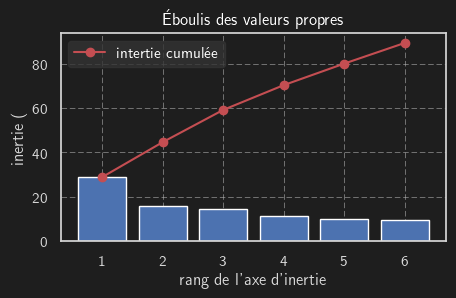

In [112]:
x_list = range(1, n_components+1)
scree = (pca.explained_variance_ratio_*100)
print('scree:', scree.round(2))
print('sum scree:', scree.sum().round(2))
fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.bar( x_list, scree )
ax.plot( x_list, scree.cumsum(), c='r', marker='o', label='intertie cumulée')
ax.legend()
ax.set_xlabel("rang de l'axe d'inertie")
ax.set_ylabel("inertie (%)")
ax.set_title('Éboulis des valeurs propres')
fig.tight_layout( )


## <a id='toc3_4_'></a>[Composantes](#toc0_)

F1    F2    F3    F4    F5    F6
energy-kj_100g                0.55  0.00  0.29  0.00 -0.10  0.01
saturated-fat_100g            0.47  0.13 -0.16 -0.10  0.09 -0.09
sugars_100g                   0.21 -0.68 -0.02  0.11  0.18 -0.27
proteins_100g                 0.10  0.59  0.04  0.03 -0.12 -0.69
salt_100g                     0.01  0.22 -0.18  0.90  0.15  0.23
non-saturated-fat_100g        0.38  0.29  0.04 -0.26  0.10  0.60
non-sugar-carbohydrates_100g  0.03 -0.10  0.69  0.26 -0.55  0.08
fiber_100g                   -0.02  0.08  0.58  0.03  0.77 -0.11
nutriscore_score              0.52 -0.17 -0.20  0.19 -0.03 -0.14

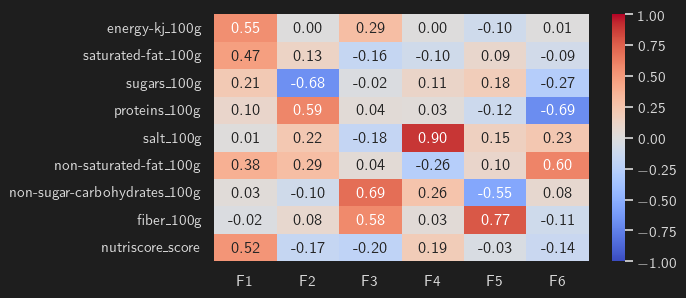

In [114]:
pcs = pd.DataFrame( pca.components_ )
pcs.columns = features
indexes = [f"F{i}" for i in x_list]
pcs.index = indexes
display( pcs.round(2).T ) #.sort_values(by=indexes , ascending=False) )
fig, ax = plt.subplots(figsize=(18*cm, 8*cm))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
fig.tight_layout( )

## <a id='toc3_5_'></a>[Cercle des corrélations](#toc0_)

In [115]:
def correlation_graph(pca,
                      ij_F,
                      features,
                      ax=None) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    ij_F : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    ax : axis sur lequel le graphique est tracé (default None -> est créé)
    """

    # Extrait x et y
    x,y=ij_F

    # Taille de l'image (en inches)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 9))
    else:
        fig = ax.get_figure()

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        ax.text(pca.components_[x, i] + 0.05*np.sign(pca.components_[x, i]),
                pca.components_[y, i] + 0.05*np.sign(pca.components_[y, i]),
                features[i])

    # Affichage des lignes horizontales et verticales
    ax.plot([-1, 1], [0, 0], color='grey', ls='--', zorder=0)
    ax.plot([0, 0], [-1, 1], color='grey', ls='--', zorder=0)

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    ax.set_ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    ax.set_title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(an), np.sin(an), zorder=0 )  # Add a unit circle for scale

    # Axes et display
    ax.axis('equal')
    plt.show(block=False)
    return fig, ax


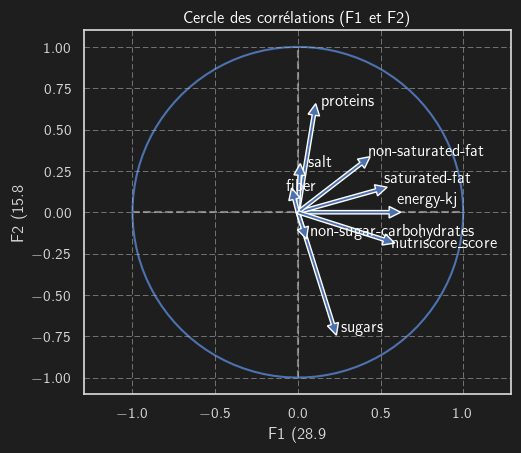

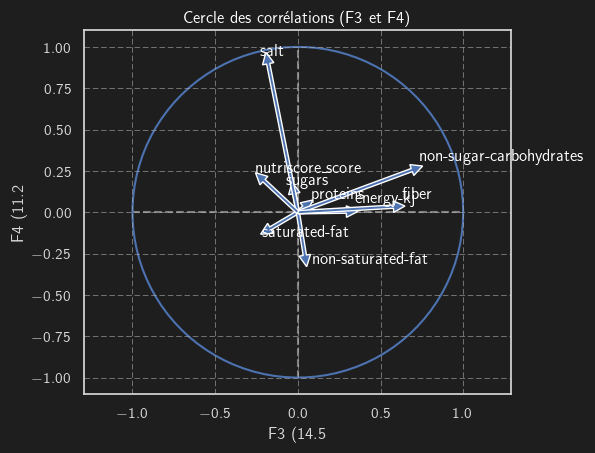

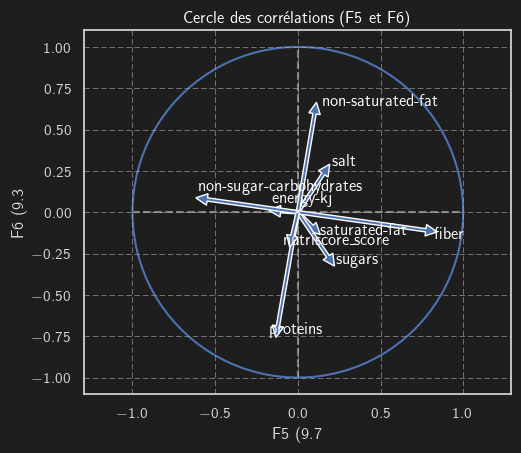

In [117]:
features_2 = [feature.replace('_100g', '') for feature in features]
# features_2[features_2.index('saturated-fat')] += '\n' # for lisibility

for i in range(3):
    fig, ax = plt.subplots( figsize=(14*cm, 12*cm))
    
    correlation_graph( pca, [i+i,i+i+1], features_2, ax=ax )
    fig.tight_layout( )

## <a id='toc3_6_'></a>[Projection - plans factoriels](#toc0_)

In [119]:

def distance_projection_on_plane_Fxy( X_scaled, X_proj, pca, x_y ):
    x,y = x_y
    X_proj_Fxy = X_proj[:,x].reshape(-1,1)*pca.components_[ x-1 ].reshape(1,-1) \
                + X_proj[:,y].reshape(-1,1)*pca.components_[ y-1 ].reshape(1,-1)
    return np.sqrt( ((X_proj_Fxy-X_scaled)**2).sum(1) )


def display_factorial_planes(   X_scaled,
                                x_y,
                                pca,
                                labels = None,
                                color=None,
                                alpha=1,
                                ax=None,
                                marker=".",
                                smin=5, smax=40 ):
    """
    Affiche la projection des individus

    DOCSTRING A METTRE A JOUR

    Positional arguments :
    -------------------------------------
    X_scaled : np.array, pd.DataFrame, list of list : la matrice des points mis à l'échelle
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None

    Optional arguments :
    -------------------------------------
    labels : list ou tuple : les labels des individus à projeter, default = None
    color : couleur des markers
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    smin : taille des markers pour la distance de projection la plus grande
    smax : taille des markers pour la distance de projection la plus faible
    """

    # Transforme X_projected en np.array
    X_ = pca.transform(X_scaled)


    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(7,6))
    else:
        fig = ax.get_figure()


    dist = -distance_projection_on_plane_Fxy( X_scaled, X_, pca, x_y )

    
    dist = smax + ( (smin-smax) /dist.ptp()) * (dist-dist.min())

    ax.scatter( X_[:,x], X_[:,y], s=dist, color=color )


    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des labels des points
    if len(labels) :
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            ax.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')

    # Titre et display
    ax.set_title(f"Projection des individus")
    return


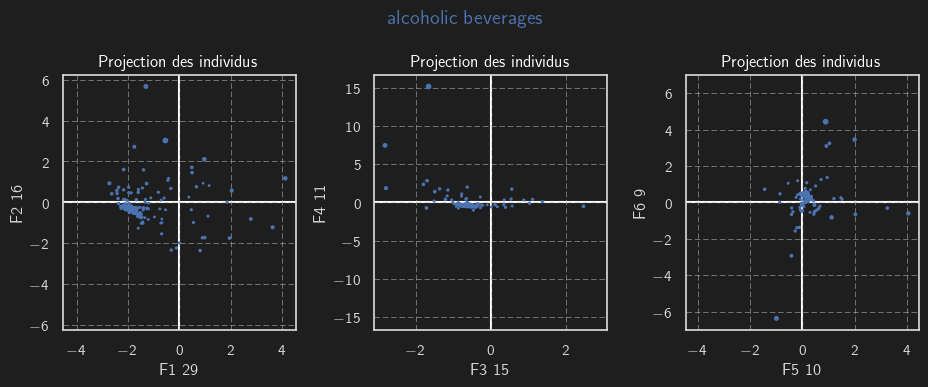

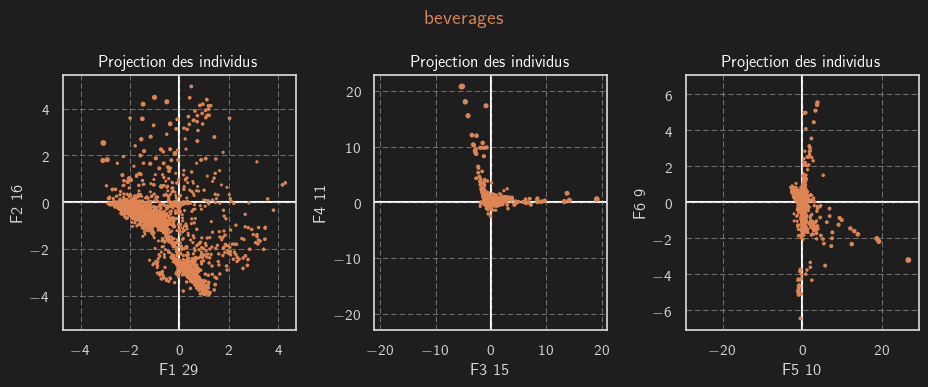

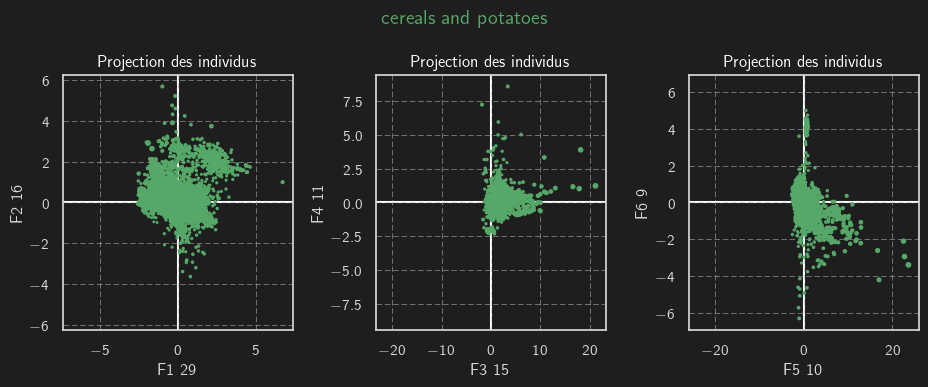

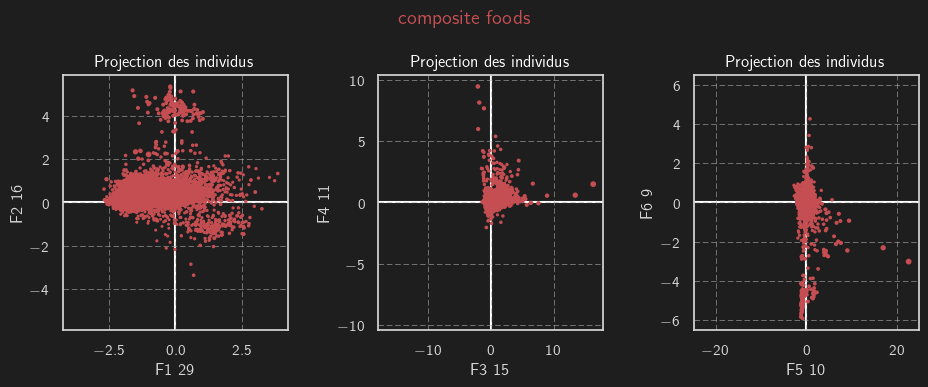

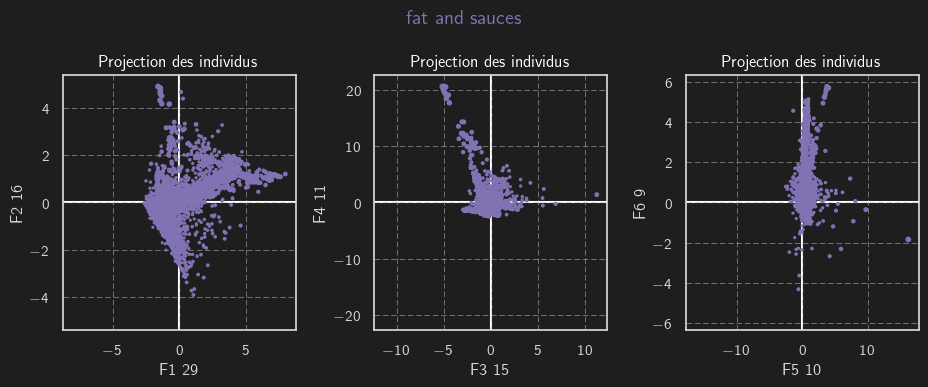

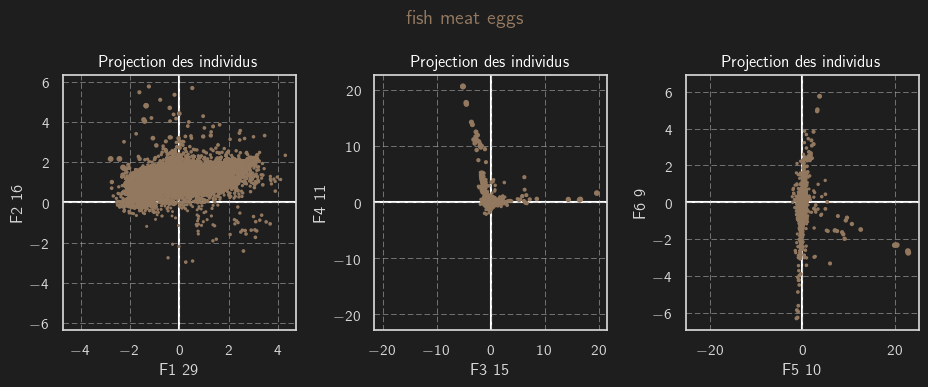

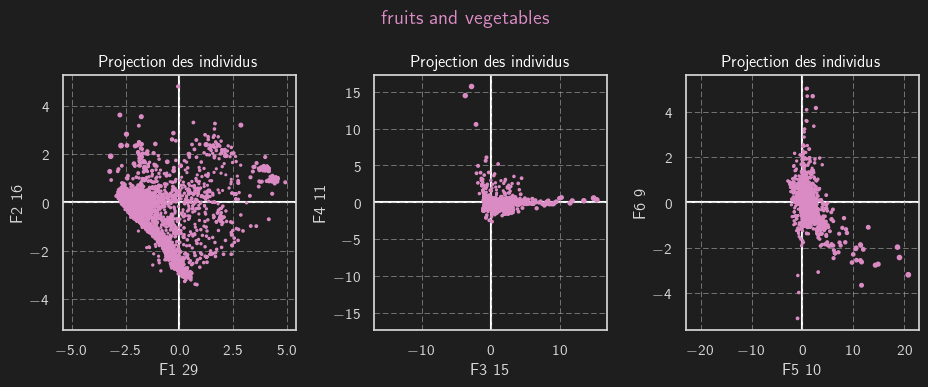

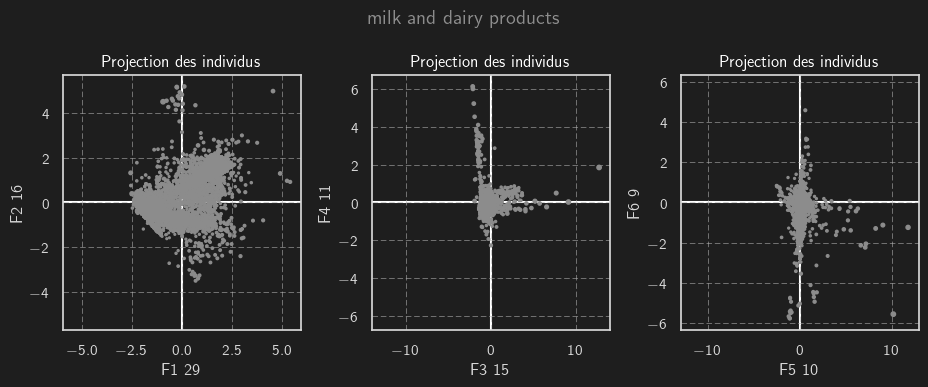

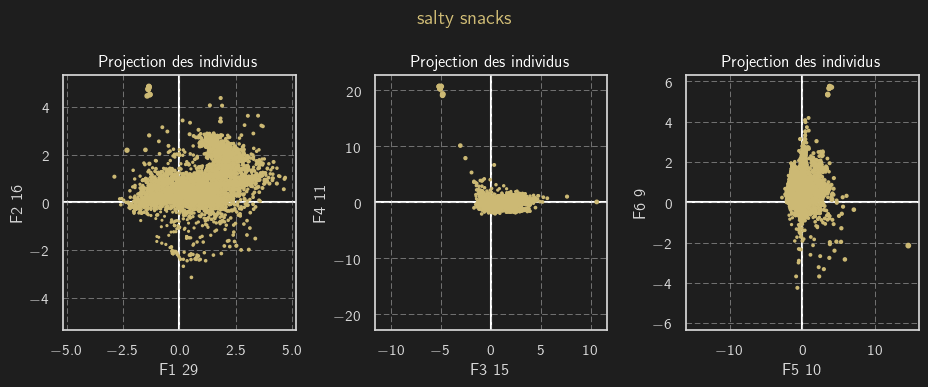

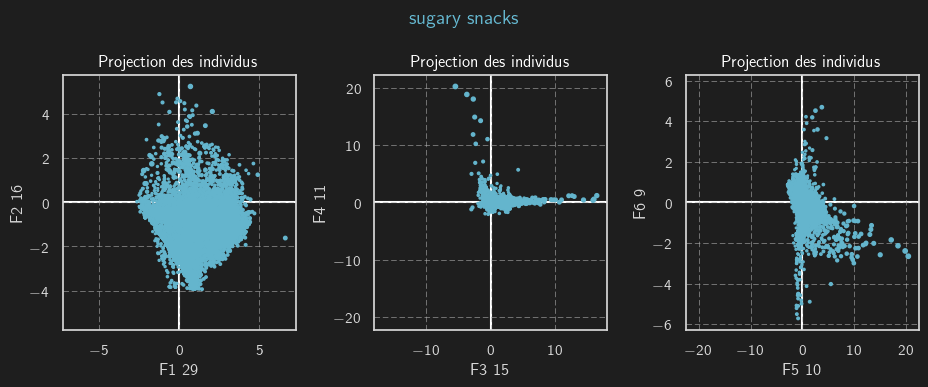

In [121]:

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
pca_pnns_groups = data.loc[ data_new.index, 'pnns_groups_1']

for name, clr in zip( data['pnns_groups_1'].cat.categories, colors ) :
    sr_loc = pca_pnns_groups == name

    fig, axs = plt.subplots( ncols=3, figsize=(24*cm,10*cm))
    fig.suptitle( name, color=clr )

    X_ = X_scaled[sr_loc.values]
    for i, ax in enumerate( axs ):
        display_factorial_planes( X_, [i+i,i+i+1], pca, labels = None,
                                    color=clr, alpha=1, ax=axs[i],
                                    marker=".", smin=1, smax=10 )
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        ax.plot( xlim, [0,0], 'w', zorder=0)
        ax.plot( [0,0], ylim, 'w', zorder=0)
    fig.tight_layout( )

***
# <a id='toc4_'></a>[Analyses liées à l'application proposée](#toc0_)

## <a id='toc4_1_'></a>[Statistiques sur la répartition des nutriscore_grade et pnns_groups](#toc0_)
- nutriscore_grade: il y a une proportion plus importante de C, D et E
- pnns_groups_1: 
    - certaines catégories contiennent relativement peu d'éléments (alocholic beverages 0.3%, salty snacks 6.9%)
    - il y a une majorité de `fish meat eggs` (16.6%) et de `sugary snacks` (20.9%)

keys: ['nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2']


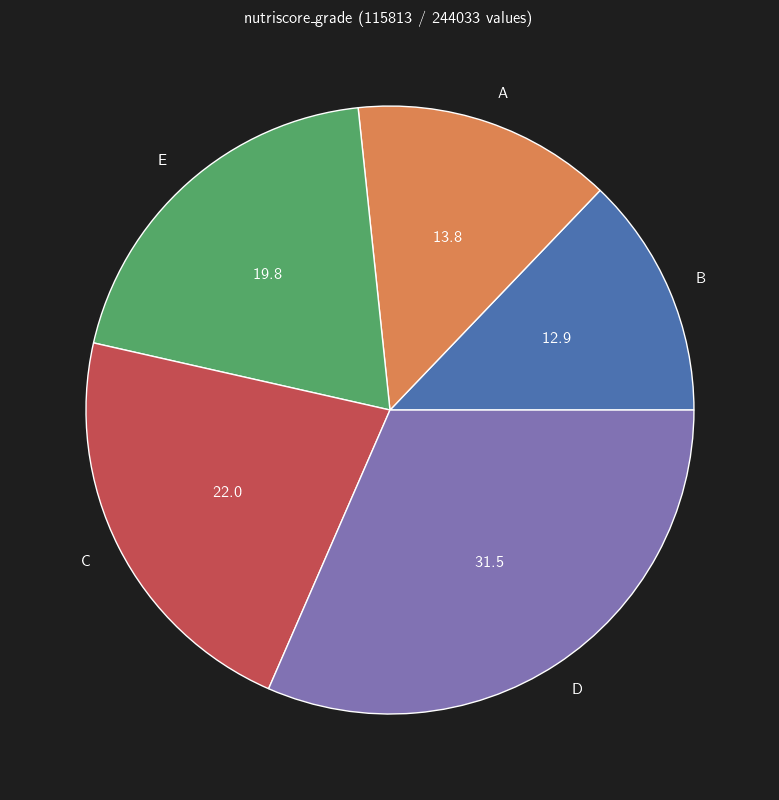

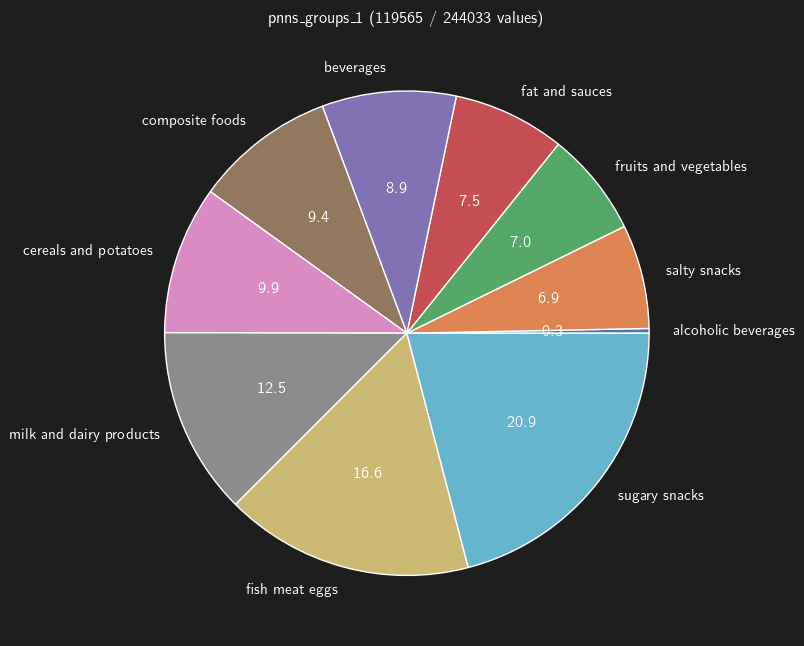

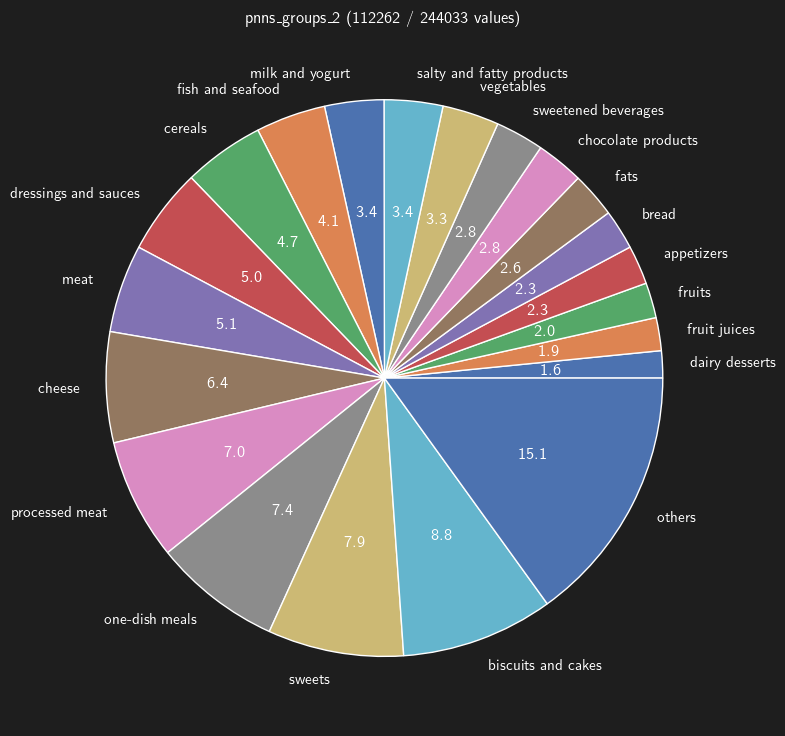

In [91]:
keys = data.keys()[data.keys().str.contains('pnns|nutriscore_grade')] #|main_categ|food_grou')]
print('keys:', keys.tolist())


n_lim_categories = 20
for key in keys:
    sr_plot = data[key].value_counts()
    n_sum = sr_plot.sum()

    if sr_plot.size > n_lim_categories:
        sr_plot = sr_plot.sort_values( ascending=False )
        sr_plot = pd.concat( [sr_plot[:n_lim_categories], 
                                pd.Series( [sr_plot[n_lim_categories:].sum()] , index=['others'] ),
                             ] )
        

    fig, ax = plt.subplots( figsize=(20*cm,20*cm))
    # pd.Series( sr_plot.sort_index( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    pd.Series( sr_plot.sort_values( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    ax.set_title( '{:} ({:} / {:} values)'.format( key, n_sum, len(data)), weight='bold')
    ax.set_ylabel('')
    fig.tight_layout( )

## <a id='toc4_2_'></a>[ANOVA](#toc0_)
Définition de fonction

In [92]:
def ANOVA(x,y):
    moyenne_y = y.mean()
    classes = {}
    for classe in x.unique():
        yi_classe = y[x==classe]
        ymean_class = yi_classe.mean()
        classes[classe] = {'n_i': len(yi_classe),
                        'moyenne_classe': ymean_class,
                        's_i': ((yi_classe-ymean_class)**2).sum() }
    SCT = ((y-moyenne_y)**2).sum()
    SCE_i = [c['n_i']*(c['moyenne_classe']-moyenne_y)**2 for c in classes.values()]
    print('SCE_i:', SCE_i)
    SCE = sum(SCE_i)
    
    return SCE, SCT, classes

Fonction basée sur l'article : "http://www.pybloggers.com/2016/02/four-ways-to-conduct-one-way-anovas-with-python/"
<br>
et sur le cours "nettoyer et analyser vos données" (OpenClassrooms)

In [93]:
from scipy import stats

def ANOVA(x,y):
    moyenne_y = y.mean()
    classes = {}
    for classe in x.unique():
        yi_classe = y[x==classe]
        ymean_class = yi_classe.mean()
        n_i = len(yi_classe)
        classes[classe] = {'n_i': n_i,
                        'moyenne_classe': ymean_class,
                        's_i': (yi_classe**2).sum() - n_i*ymean_class**2 }
    k = len(classes) # number of condittions
    N = len(y) # number of values

    # Degree of Freedom (DF)
    DFbetween = k - 1
    DFwithin = N - k
    DFtotal = N - 1

    # Sum of Squares (SS)
    SStotal = (y**2).sum() - N*moyenne_y**2
    SSbetween = sum([c['n_i']*(c['moyenne_classe']-moyenne_y)**2 for c in classes.values()])
    SSwithin = sum( [c['s_i'] for c in classes.values()] )

    # Meas Square
    MSbetween = SSbetween/DFbetween
    MSwithin = SSwithin/DFwithin

    F = MSbetween/MSwithin
    p = stats.f.sf( F, DFbetween, DFwithin )
    eta_sqrd = SSbetween/SStotal

    omega_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)

    return F,p, eta_sqrd, omega_sqrd, classes

Test sur différentes variables `nutriscore_grade` et `salt`.

Q3 + 1.5*IQ: 3.23


count   mean    std  min   25%   50%    75%      max
before crop  115796.0  1.065  2.528  0.0  0.09  0.60  1.345  100.000
after crop   109680.0  0.726  0.746  0.0  0.08  0.53  1.200    3.226

F: 3247.420, p: 0.0 eta_sqrd: 0.106 omega_sqrd: 0.106


sum_sq        df        F PR(>F) eta_sqrd omega_sqrd
nutriscore_grade   6456.376       4.0  3247.42    0.0    0.106      0.106
Residual          54512.732  109675.0

mean_classes: [0.28521552 0.53017336 0.70088671 1.01029113 0.77855031]


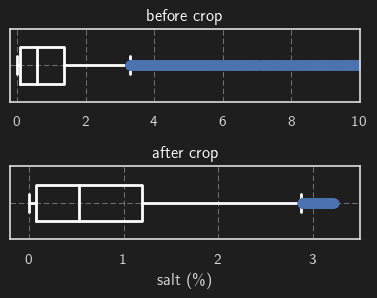

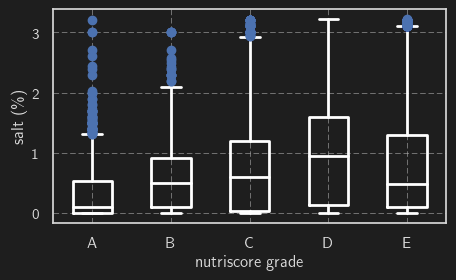

In [103]:
X,Y = 'nutriscore_grade', 'salt_100g'
df = data[[X,Y]].dropna()

df_describe = df[[Y]].describe()

# Q3 + 1.5*IQ
vlim = df_describe[Y]['75%']*2.5 - 1.5*df_describe[Y]['25%']
print('Q3 + 1.5*IQ: {:.2f}'.format( vlim ))

# ommition des valeurs abérrantes
# les valeurs atypiques sont aussi ommises puisqu'inférieur à Q3+1.5*IQ
# (ex paquet de sel)
df = df.loc[df[Y] < vlim, :]


 

df_describe = pd.concat((df_describe.T, df[[Y]].describe().T))
df_describe.index = ['before crop', 'after crop']

display( df_describe.round(3) )

F,p, eta_sqrd, omega_sqrd, classes = ANOVA( df[X], df[Y] )

print('F: {:.3f},'.format(F), 'p:', p, 'eta_sqrd: {:.3f} omega_sqrd: {:.3f}'.format( eta_sqrd, omega_sqrd) )


import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols( Y + ' ~ ' + X, data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table[['eta_sqrd', 'omega_sqrd']] = np.nan
aov_table.loc[ X, 'eta_sqrd' ] = eta_sqrd
aov_table.loc[ X, 'omega_sqrd' ] = omega_sqrd
display( aov_table.round(3).fillna('') )


grades = ['A', 'B', 'C', 'D', 'E']


mean_classes = np.array( [classes[grade]['moyenne_classe'] for grade in grades] )
print('mean_classes:', mean_classes)

grades = [ '{:}\n({:})'.format( grade, classes[grade]['n_i'] ) for grade in grades ]

props = {'color':'w', 'linewidth':2}

fig, axs = plt.subplots( nrows=2,  figsize=(10*cm,8*cm))
data.boxplot( column=Y, vert=False, ax=axs[0], sym='bo', 
            boxprops=props, whiskerprops=props,
            capprops=props, medianprops=props,
            widths=0.5 )
df.boxplot( column=Y, vert=False, ax=axs[1], sym='bo', 
            boxprops=props, whiskerprops=props,
            capprops=props, medianprops=props,
            widths=0.5 )
axs[0].set_xlim([-0.2, 10])
axs[1].set_xlim([-0.2, 3.5])
axs[1].set_xlabel(Y.replace('_100g', ' (\%)'))
axs[0].set_title( r'before crop' )
axs[1].set_title( r'after crop' )
axs[0].set_yticklabels( [] )
axs[1].set_yticklabels( [] )
fig.tight_layout( )

fig, ax = plt.subplots( figsize=(12*cm, 8*cm) )
df.boxplot( column=Y, by=X, ax=ax, sym='bo', 
            boxprops=props, whiskerprops=props,
            capprops=props, medianprops=props,
            widths=0.5)
ax.set_ylabel(Y.replace('_100g', ' (\%)'))
ax.set_xlabel(X.replace('_', ' '))
ax.set_title('')
fig.suptitle(None)
fig.tight_layout( )

Visualisation en histogrammes à partir du corrigé du webinaire "Interprétez des tendances à l'aide de visualisations graphiques"

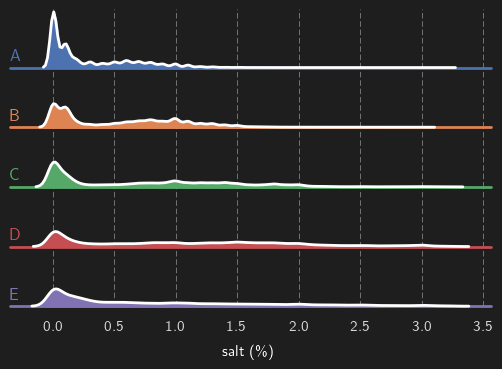

In [106]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row=X, hue=X, aspect=7, height=0.8) #, palette=pal)

# Draw the densities in a few steps
g.map(plt.axhline, y=0, lw=2, clip_on=False) # horizontal axes lines
g.map(sns.kdeplot, Y,
      bw_adjust=.5, clip_on=False, log_scale=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, Y, clip_on=False, color="w", lw=2, bw_adjust=.5)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, Y)
g.fig.text(x=0.53, y=0.04, 
           horizontalalignment='center', #make sure it's aligned at center horizontally
           s=Y.replace('_100g', ' (\%)'), #this is the text in the xlabel
           size=11)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=.02)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_axis_labels('','')
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.set_ylabels('')


## <a id='toc4_3_'></a>[Scatter plots](#toc0_)
On observe une corrélation partielle pour les sucres, carbohydrates et graisses (nuage en forme de haricot).

Le nutriscore est visiblement lié à plusieurs variables.

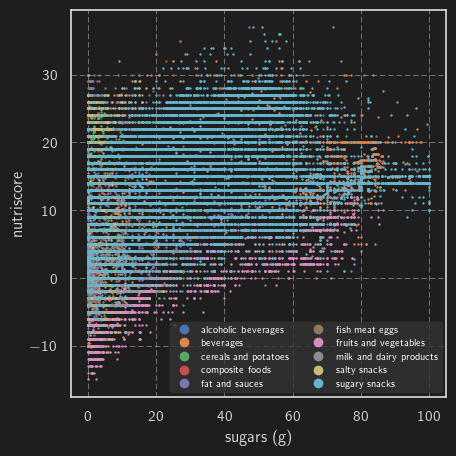

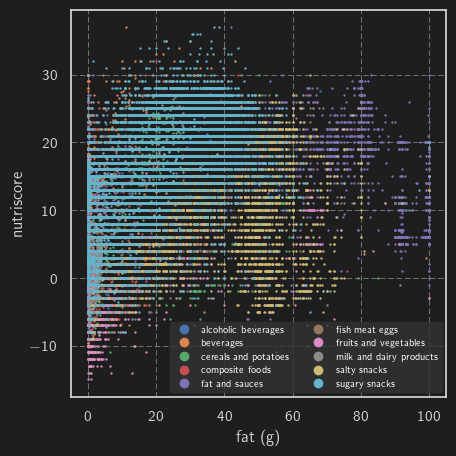

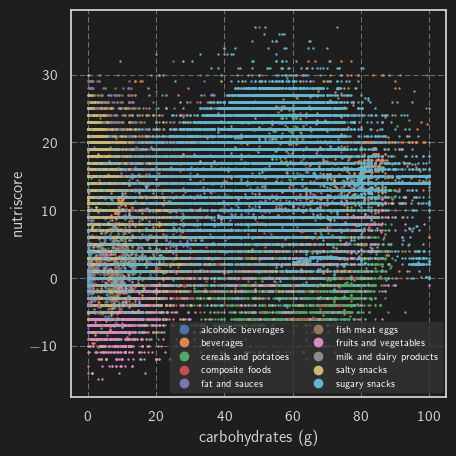

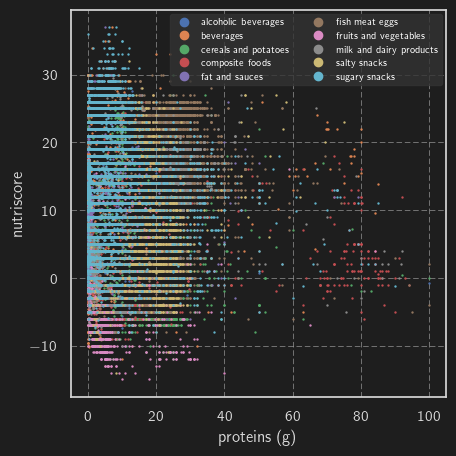

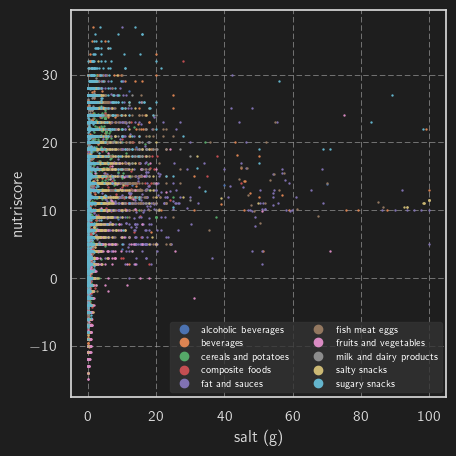

In [108]:
groups = data.groupby( 'pnns_groups_1' )

for key in ['sugars', 'fat', 'carbohydrates', 'proteins', 'salt']:
    fig, ax = plt.subplots( figsize=(12*cm,12*cm))
    for name, group in groups:
        ax.plot( group[key+ '_100g'], group['nutriscore_score'], 'o', markersize=0.7, label=name )
    ax.set_xlabel( key + ' (g)' )
    ax.set_ylabel( 'nutriscore' )
    lgnd = ax.legend( ncol=2, fontsize=7 )
    for handle in lgnd.legendHandles:
        handle.set_markersize(6.0) # change markersize in legend
    fig.tight_layout( )

## <a id='toc4_4_'></a>[Observations des listes d'ingrédients](#toc0_)

In [6]:
for value in data[['ingredients_text']].dropna().values[:10]:
    print('\n{:}'.format(value[0]))


lait entier (99%); poudre de lait (1%), ferments lactiques, présure.

jus d'orange 40% - jus de pomme 40% - jus d'ananas 9% - purée de banane - jus de raisin blanc - jus de pamplemousse - purée d'abricot - purée de pêche.

1 boite  de garniture: tomates fraiches (51%), eau, oignons frais, huile d'olive vierge extra, huile de colza, sel, persil, concentré de tomate, jus concentré de citron, menthe, épaississants: farine de graines de caroube et gomme guar, arômes. 1 coupelle de semoule de blé dur précuite à la vapeur.

farine de blé, sucre, beurre 12% (lait), sirop de sucre inverti, poudres à lever: carbonates de sodium, diphosphates, lactosérum en poudre lait), lat entier en poudre, sel, émulsifiant: lécithine de soja; acidifiant : acide citrique; arôme (oeufs entiers en poudre).

palette de porc avec os 90 %, eau, sel, dextrose, conservateur : nitrite de sodium.

_lait_ de vache pasteurisé - sel - correcteur d'acidité : acide citrique.

_lait_ cru, sel, ferments lactiques, présure.



Affichage d'un histogramme correspondant au ratio count(%) / count(séparateur).
<br>
Certaines listes sont possiblement différentes, générant des valeurs aberrantes.

Le calcul donne tout de mêmes des informations intéressantes: les pourcentages des différents ingrédients sont rarement complètement renseignés.

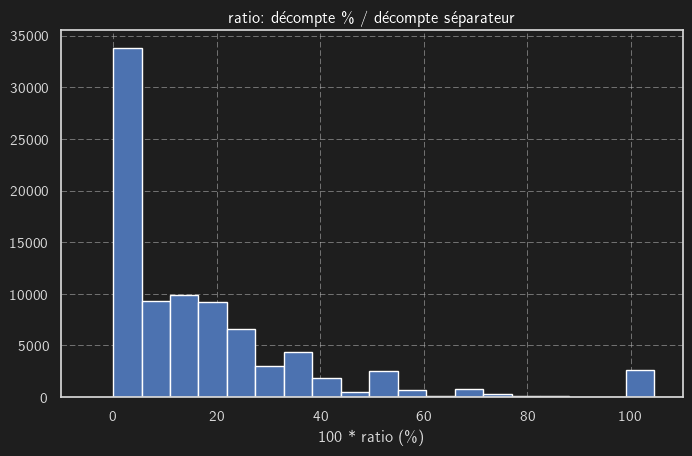

In [11]:
def count_ratio_percent_sep( str_in ):
    return str_in.count('%') / ( 1+ str_in.count(',') + str_in.count(';') + str_in.count('-') )

lst_ratio = []
for value in data[['ingredients_text']].dropna().values:
    lst_ratio.append( count_ratio_percent_sep( value[0] ) *100 )

fig, ax = plt.subplots( figsize=(18*cm,12*cm))
ax.hist( lst_ratio , bins=200)
ax.set_xlim([-10,110])
ax.set_title('ratio: décompte \% / décompte séparateur')
ax.set_xlabel('100 * ratio (\%)')
fig.tight_layout( )